In [ ]:
import numpy as np
import cv2
import scipy.io
import os
from numpy.linalg import norm
from matplotlib import pyplot as plt
from numpy.linalg import det
from numpy.linalg import inv
from scipy.linalg import rq
from numpy.linalg import svd
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import sys
from scipy import ndimage, spatial
from tqdm.notebook import tqdm, trange

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from skimage import io, transform,data
from torchvision import transforms, utils
import numpy as np
import math
import glob
import matplotlib.pyplot as plt
import time
import os
import copy
import sklearn.svm
import cv2
from matplotlib import pyplot as plt
import numpy as np
from os.path import exists
import pandas as pd
import PIL
import random
from google.colab import drive
from sklearn.metrics.cluster import completeness_score
from sklearn.cluster import KMeans
from tqdm import tqdm, tqdm_notebook
from functools import partial
from torchsummary import summary
from torchvision.datasets import ImageFolder
from torch.utils.data.sampler import SubsetRandomSampler

In [ ]:
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install opencv-python==3.4.2.17
!pip install opencv-contrib-python==3.4.2.17

     |████████████████████████████████| 25.0MB 123kB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30


     |████████████████████████████████| 30.6MB 73kB/s 
  Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Successfully uninstalled opencv-contrib-python-4.1.2.30


In [ ]:
class Image:
    def __init__(self, img, position):
        
        self.img = img
        self.position = position

inlier_matchset = []
def features_matching(a,keypointlength,threshold):
  #threshold=0.2
  bestmatch=np.empty((keypointlength),dtype= np.int16)
  img1index=np.empty((keypointlength),dtype=np.int16)
  distance=np.empty((keypointlength))
  index=0
  for j in range(0,keypointlength):
    #For a descriptor fa in Ia, take the two closest descriptors fb1 and fb2 in Ib
    x=a[j]
    listx=x.tolist()
    x.sort()
    minval1=x[0]                                # min 
    minval2=x[1]                                # 2nd min
    itemindex1 = listx.index(minval1)           #index of min val    
    itemindex2 = listx.index(minval2)           #index of second min value 
    ratio=minval1/minval2                       #Ratio Test
    
    if ratio<threshold: 
      #Low distance ratio: fb1 can be a good match
      bestmatch[index]=itemindex1
      distance[index]=minval1
      img1index[index]=j
      index=index+1
  return  [cv2.DMatch(img1index[i],bestmatch[i].astype(int),distance[i]) for i in range(0,index)]
          
   
  
def compute_Homography(im1_pts,im2_pts):
  """
  im1_pts and im2_pts are 2×n matrices with
  4 point correspondences from the two images
  """
  num_matches=len(im1_pts)
  num_rows = 2 * num_matches
  num_cols = 9
  A_matrix_shape = (num_rows,num_cols)
  A = np.zeros(A_matrix_shape)
  a_index = 0
  for i in range(0,num_matches):
    (a_x, a_y) = im1_pts[i]
    (b_x, b_y) = im2_pts[i]
    row1 = [a_x, a_y, 1, 0, 0, 0, -b_x*a_x, -b_x*a_y, -b_x] # First row 
    row2 = [0, 0, 0, a_x, a_y, 1, -b_y*a_x, -b_y*a_y, -b_y] # Second row 

    # place the rows in the matrix
    A[a_index] = row1
    A[a_index+1] = row2

    a_index += 2
    
  U, s, Vt = np.linalg.svd(A)

  #s is a 1-D array of singular values sorted in descending order
  #U, Vt are unitary matrices
  #Rows of Vt are the eigenvectors of A^TA.
  #Columns of U are the eigenvectors of AA^T.
  H = np.eye(3)
  H = Vt[-1].reshape(3,3) # take the last row of the Vt matrix
  return H
  
  
def displayplot(img,title):
  
  plt.figure(figsize=(15,15))
  plt.title(title)
  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  plt.show()

In [ ]:
def get_inliers(f1, f2, matches, H, RANSACthresh):

  inlier_indices = []
  for i in range(len(matches)):
    queryInd = matches[i].queryIdx
    trainInd = matches[i].trainIdx

    #queryInd = matches[i][0]
    #trainInd = matches[i][1]

    queryPoint = np.array([f1[queryInd].pt[0],  f1[queryInd].pt[1], 1]).T 
    trans_query = H.dot(queryPoint) 

   
    comp1 = [trans_query[0]/trans_query[2], trans_query[1]/trans_query[2]] # normalize with respect to z
    comp2 = np.array(f2[trainInd].pt)[:2]
    

    if(np.linalg.norm(comp1-comp2) <= RANSACthresh): # check against threshold
      inlier_indices.append(i)
  return inlier_indices


def RANSAC_alg(f1, f2, matches, nRANSAC, RANSACthresh):

      
    minMatches = 4
    nBest = 0
    best_inliers = []
    H_estimate = np.eye(3,3)
    global inlier_matchset
    inlier_matchset=[]
    for iteration in range(nRANSAC):
      
        #Choose a minimal set of feature matches.
        matchSample = random.sample(matches, minMatches)
        
        #Estimate the Homography implied by these matches
        im1_pts=np.empty((minMatches,2))
        im2_pts=np.empty((minMatches,2))
        for i in range(0,minMatches):
          m = matchSample[i]
          im1_pts[i] = f1[m.queryIdx].pt
          im2_pts[i] = f2[m.trainIdx].pt
          #im1_pts[i] = f1[m[0]].pt
          #im2_pts[i] = f2[m[1]].pt             
          
        H_estimate=compute_Homography(im1_pts,im2_pts)
        
               
        # Calculate the inliers for the H
        inliers = get_inliers(f1, f2, matches, H_estimate, RANSACthresh)

        # if the number of inliers is higher than previous iterations, update the best estimates
        if len(inliers) > nBest:
            nBest= len(inliers)
            best_inliers = inliers

    print("Number of best inliers",len(best_inliers))
    for i in range(len(best_inliers)):
      inlier_matchset.append(matches[best_inliers[i]])
    
    # compute a homography given this set of matches
    im1_pts=np.empty((len(best_inliers),2))
    im2_pts=np.empty((len(best_inliers),2))
    for i in range(0,len(best_inliers)):
      m = inlier_matchset[i]
      im1_pts[i] = f1[m.queryIdx].pt
      im2_pts[i] = f2[m.trainIdx].pt
      #im1_pts[i] = f1[m[0]].pt
      #im2_pts[i] = f2[m[1]].pt

    M=compute_Homography(im1_pts,im2_pts)
    return M, best_inliers

In [ ]:
files_all=[]
for file in os.listdir("/content/drive/MyDrive/RGB-img/img"):
    if file.endswith(".JPG"):
      files_all.append(file)


files_all.sort()
folder_path = '/content/drive/MyDrive/RGB-img/img/'

centre_file = folder_path + files_all[15]
left_files_path_rev = []
right_files_path = []

for file in files_all[:51]:
  left_files_path_rev.append(folder_path + file)

left_files_path = left_files_path_rev[::-1]

for file in files_all[50:101]:
  right_files_path.append(folder_path + file)

In [ ]:
from PIL.ExifTags import TAGS
from PIL.ExifTags import GPSTAGS
from PIL import Image
def get_exif(filename):
    image = Image.open(filename)
    image.verify()
    return image._getexif()
    
def get_labeled_exif(exif):
    labeled = {}
    for (key, val) in exif.items():
        labeled[TAGS.get(key)] = val

    return labeled


def get_geotagging(exif):
    if not exif:
        raise ValueError("No EXIF metadata found")

    geotagging = {}
    for (idx, tag) in TAGS.items():
        if tag == 'GPSInfo':
            if idx not in exif:
                raise ValueError("No EXIF geotagging found")

            for (key, val) in GPSTAGS.items():
                if key in exif[idx]:
                    geotagging[val] = exif[idx][key]
    return geotagging

def get_decimal_from_dms(dms, ref):

    degrees = dms[0][0] / dms[0][1]
    minutes = dms[1][0] / dms[1][1] / 60.0
    seconds = dms[2][0] / dms[2][1] / 3600.0

    if ref in ['S', 'W']:
        degrees = -degrees
        minutes = -minutes
        seconds = -seconds

    return round(degrees + minutes + seconds, 5)

def get_coordinates(geotags):
    lat = get_decimal_from_dms(geotags['GPSLatitude'], geotags['GPSLatitudeRef'])

    lon = get_decimal_from_dms(geotags['GPSLongitude'], geotags['GPSLongitudeRef'])

    return (lat,lon)

In [ ]:
gridsize = 8
clahe = cv2.createCLAHE(clipLimit=2.0,tileGridSize=(gridsize,gridsize))

images_left_bgr = []
images_right_bgr = []

images_left = []
images_right = []

for file in tqdm(left_files_path):
  left_image_sat= cv2.imread(file)
  lab = cv2.cvtColor(left_image_sat, cv2.COLOR_BGR2LAB)
  lab[...,0] = clahe.apply(lab[...,0])
  left_image_sat = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
  left_img = cv2.resize(left_image_sat,None,fx=0.35, fy=0.35, interpolation = cv2.INTER_CUBIC)
  images_left.append(cv2.cvtColor(left_img, cv2.COLOR_BGR2GRAY).astype('float32')/255.)
  images_left_bgr.append(left_img)


for file in tqdm(right_files_path):
  right_image_sat= cv2.imread(file)
  lab = cv2.cvtColor(right_image_sat, cv2.COLOR_BGR2LAB)
  lab[...,0] = clahe.apply(lab[...,0])
  right_image_sat = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
  right_img = cv2.resize(right_image_sat,None,fx=0.35,fy=0.35, interpolation = cv2.INTER_CUBIC)
  images_right.append(cv2.cvtColor(right_img, cv2.COLOR_BGR2GRAY).astype('float32')/255.)
  images_right_bgr.append(right_img)

100%|██████████| 51/51 [01:01<00:00,  1.21s/it]


In [ ]:
images_left_bgr_no_enhance = []
images_right_bgr_no_enhance = []


for file in tqdm(left_files_path):
  left_image_sat= cv2.imread(file)
  left_img = cv2.resize(left_image_sat,None,fx=0.35, fy=0.35, interpolation = cv2.INTER_CUBIC)
  images_left_bgr_no_enhance.append(left_img)


for file in tqdm(right_files_path):
  right_image_sat= cv2.imread(file)
  right_img = cv2.resize(right_image_sat,None,fx=0.35,fy=0.35, interpolation = cv2.INTER_CUBIC)
  images_right_bgr_no_enhance.append(right_img)

100%|██████████| 51/51 [00:22<00:00,  2.24it/s]


In [ ]:
sift = cv2.xfeatures2d.SIFT_create()
keypoints_all_left_sift = []
descriptors_all_left_sift = []
points_all_left_sift=[]

keypoints_all_right_sift = []
descriptors_all_right_sift = []
points_all_right_sift=[]

for imgs in tqdm(images_left_bgr):
  kpt = sift.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_left_sift.append(kpt)
  descriptors_all_left_sift.append(descrip)
  points_all_left_sift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for imgs in tqdm(images_right_bgr):
  kpt = sift.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_right_sift.append(kpt)
  descriptors_all_right_sift.append(descrip)
  points_all_right_sift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

In [ ]:
def compute_homography_fast(matched_pts1, matched_pts2,thresh=4):
    #matched_pts1 = cv2.KeyPoint_convert(matched_kp1)
    #matched_pts2 = cv2.KeyPoint_convert(matched_kp2)

    # Estimate the homography between the matches using RANSAC
    H, inliers = cv2.findHomography(matched_pts1,
                                    matched_pts2,
                                    cv2.RANSAC, ransacReprojThreshold =thresh)
    inliers = inliers.flatten()
    return H, inliers

In [ ]:
def compute_homography_fast_other(matched_pts1, matched_pts2):
    #matched_pts1 = cv2.KeyPoint_convert(matched_kp1)
    #matched_pts2 = cv2.KeyPoint_convert(matched_kp2)

    # Estimate the homography between the matches using RANSAC
    H, inliers = cv2.findHomography(matched_pts1,
                                    matched_pts2,
                                    0)
    inliers = inliers.flatten()
    return H, inliers

In [ ]:
def get_Hmatrix(imgs,keypts,pts,descripts,ratio=0.8,thresh=4,disp=False):
  FLANN_INDEX_KDTREE = 2
  index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
  search_params = dict(checks=50)
  flann = cv2.FlannBasedMatcher(index_params, search_params)
  #flann = cv2.BFMatcher()

  lff1 = np.float32(descripts[0])
  lff = np.float32(descripts[1])


  matches_lf1_lf = flann.knnMatch(lff1, lff, k=2)

  print("\nNumber of matches",len(matches_lf1_lf))

  matches_4 = []
  ratio = ratio
  # loop over the raw matches
  for m in matches_lf1_lf:
    # ensure the distance is within a certain ratio of each
    # other (i.e. Lowe’s ratio test)
    if len(m) == 2 and m[0].distance < m[1].distance * ratio:
        #matches_1.append((m[0].trainIdx, m[0].queryIdx))
        matches_4.append(m[0])

  print("Number of matches After Lowe's Ratio",len(matches_4))
  
  matches_idx = np.array([m.queryIdx for m in matches_4])
  imm1_pts = np.array([keypts[0][idx].pt for idx in matches_idx])
  matches_idx = np.array([m.trainIdx for m in matches_4])
  imm2_pts = np.array([keypts[1][idx].pt for idx in matches_idx])
  '''
  # Estimate homography 1
  #Compute H1
  # Estimate homography 1
  #Compute H1
  imm1_pts=np.empty((len(matches_4),2))
  imm2_pts=np.empty((len(matches_4),2))
  for i in range(0,len(matches_4)):
    m = matches_4[i]
    (a_x, a_y) = keypts[0][m.queryIdx].pt
    (b_x, b_y) = keypts[1][m.trainIdx].pt
    imm1_pts[i]=(a_x, a_y)
    imm2_pts[i]=(b_x, b_y)    
  H=compute_Homography(imm1_pts,imm2_pts) 
  #Robustly estimate Homography 1 using RANSAC
  Hn, best_inliers=RANSAC_alg(keypts[0] ,keypts[1], matches_4,  nRANSAC=1000, RANSACthresh=6)
  '''
  
  
  Hn,inliers = compute_homography_fast(imm1_pts,imm2_pts,thresh)  
  inlier_matchset = np.array(matches_4)[inliers.astype(bool)].tolist()
  print("Number of Robust matches",len(inlier_matchset))
  print("\n")
  '''
  if len(inlier_matchset)<50:
    matches_4 = []
    ratio = 0.67
    # loop over the raw matches
    for m in matches_lf1_lf:
      # ensure the distance is within a certain ratio of each
      # other (i.e. Lowe’s ratio test)
      if len(m) == 2 and m[0].distance < m[1].distance * ratio:
          #matches_1.append((m[0].trainIdx, m[0].queryIdx))
          matches_4.append(m[0])
    print("Number of matches After Lowe's Ratio New",len(matches_4))
  
    matches_idx = np.array([m.queryIdx for m in matches_4])
    imm1_pts = np.array([keypts[0][idx].pt for idx in matches_idx])
    matches_idx = np.array([m.trainIdx for m in matches_4])
    imm2_pts = np.array([keypts[1][idx].pt for idx in matches_idx])
    Hn,inliers = compute_homography_fast_other(imm1_pts,imm2_pts)  
    inlier_matchset = np.array(matches_4)[inliers.astype(bool)].tolist()
    print("Number of Robust matches New",len(inlier_matchset))
    print("\n")    
    '''
  #H=compute_Homography(imm1_pts,imm2_pts) 
  #Robustly estimate Homography 1 using RANSAC
  #Hn=RANSAC_alg(keypts[0] ,keypts[1], matches_4,  nRANSAC=1500, RANSACthresh=6)

  #global inlier_matchset   
  
  if disp==True:
    dispimg1=cv2.drawMatches(imgs[0], keypts[0], imgs[1], keypts[1], inlier_matchset, None,flags=2)
    displayplot(dispimg1,'Robust Matching between Reference Image and Right Image ')
  
  return Hn/Hn[2,2], len(matches_lf1_lf), len(inlier_matchset)

In [ ]:
from functools import partial
from tqdm import tqdm
tqdm = partial(tqdm, position=0, leave=True)

In [ ]:
print(left_files_path)

['/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0051.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0050.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0049.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0048.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0047.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0046.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0045.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0044.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0043.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0042.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0041.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0040.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0039.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0038.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0037.JPG', '/content/drive/MyDrive/RGB-img/img/IX-

In [ ]:
print(right_files_path)

['/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0051.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0052.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0053.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0054.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0055.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0056.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0057.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0058.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0059.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0060.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0061.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0062.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0063.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0064.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0065.JPG', '/content/drive/MyDrive/RGB-img/img/IX-

In [ ]:
H_left_sift = []
H_right_sift = []

num_matches_sift = []
num_good_matches_sift = []

for j in tqdm(range(len(images_left))):
  if j==len(images_left)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_sift[j:j+2][::-1],points_all_left_sift[j:j+2][::-1],descriptors_all_left_sift[j:j+2][::-1],0.5)
  H_left_sift.append(H_a)
  num_matches_sift.append(matches)
  num_good_matches_sift.append(gd_matches)

for j in tqdm(range(len(images_right))):
  if j==len(images_right)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_sift[j:j+2][::-1],points_all_right_sift[j:j+2][::-1],descriptors_all_right_sift[j:j+2][::-1],0.5)
  H_right_sift.append(H_a)
  #num_matches.append(matches)
  #num_good_matches.append(gd_matches)

  2%|▏         | 1/51 [00:02<02:24,  2.89s/it]


Number of matches 27909
Number of matches After Lowe's Ratio 1299
Number of Robust matches 923




  4%|▍         | 2/51 [00:06<02:39,  3.25s/it]


Number of matches 24162
Number of matches After Lowe's Ratio 1461
Number of Robust matches 1163




  6%|▌         | 3/51 [00:10<02:32,  3.18s/it]


Number of matches 27592
Number of matches After Lowe's Ratio 1427
Number of Robust matches 1093




  8%|▊         | 4/51 [00:13<02:32,  3.24s/it]


Number of matches 27282
Number of matches After Lowe's Ratio 2418
Number of Robust matches 2124




 10%|▉         | 5/51 [00:16<02:30,  3.28s/it]


Number of matches 27099
Number of matches After Lowe's Ratio 1689
Number of Robust matches 1509




 12%|█▏        | 6/51 [00:20<02:28,  3.30s/it]


Number of matches 25919
Number of matches After Lowe's Ratio 2061
Number of Robust matches 1808




 14%|█▎        | 7/51 [00:23<02:24,  3.28s/it]


Number of matches 26581
Number of matches After Lowe's Ratio 1901
Number of Robust matches 1593




 16%|█▌        | 8/51 [00:26<02:22,  3.32s/it]


Number of matches 27052
Number of matches After Lowe's Ratio 2794
Number of Robust matches 2312




 18%|█▊        | 9/51 [00:30<02:20,  3.34s/it]


Number of matches 28182
Number of matches After Lowe's Ratio 3199
Number of Robust matches 2838




 20%|█▉        | 10/51 [00:34<02:31,  3.69s/it]


Number of matches 29913
Number of matches After Lowe's Ratio 2433
Number of Robust matches 2074




 22%|██▏       | 11/51 [00:39<02:41,  4.04s/it]


Number of matches 32208
Number of matches After Lowe's Ratio 1909
Number of Robust matches 1414




 24%|██▎       | 12/51 [00:44<02:49,  4.35s/it]


Number of matches 31209
Number of matches After Lowe's Ratio 1621
Number of Robust matches 1320




 25%|██▌       | 13/51 [00:49<02:53,  4.57s/it]


Number of matches 31666
Number of matches After Lowe's Ratio 1752
Number of Robust matches 1359




 27%|██▋       | 14/51 [00:54<02:54,  4.72s/it]


Number of matches 31039
Number of matches After Lowe's Ratio 1273
Number of Robust matches 1084




 29%|██▉       | 15/51 [00:59<02:54,  4.86s/it]


Number of matches 35893
Number of matches After Lowe's Ratio 1038
Number of Robust matches 714




 31%|███▏      | 16/51 [01:05<02:57,  5.06s/it]


Number of matches 30633
Number of matches After Lowe's Ratio 1052
Number of Robust matches 776




 33%|███▎      | 17/51 [01:10<02:49,  4.98s/it]


Number of matches 35656
Number of matches After Lowe's Ratio 1096
Number of Robust matches 742




 35%|███▌      | 18/51 [01:15<02:50,  5.17s/it]


Number of matches 34271
Number of matches After Lowe's Ratio 1066
Number of Robust matches 660




 37%|███▋      | 19/51 [01:21<02:53,  5.41s/it]


Number of matches 39115
Number of matches After Lowe's Ratio 613
Number of Robust matches 427




 39%|███▉      | 20/51 [01:28<02:56,  5.69s/it]


Number of matches 38049
Number of matches After Lowe's Ratio 1096
Number of Robust matches 740




 41%|████      | 21/51 [01:34<02:54,  5.82s/it]


Number of matches 38187
Number of matches After Lowe's Ratio 416
Number of Robust matches 258




 43%|████▎     | 22/51 [01:40<02:48,  5.83s/it]


Number of matches 35025
Number of matches After Lowe's Ratio 117
Number of Robust matches 80




 45%|████▌     | 23/51 [01:45<02:40,  5.75s/it]


Number of matches 35065
Number of matches After Lowe's Ratio 1058
Number of Robust matches 853




 47%|████▋     | 24/51 [01:51<02:31,  5.62s/it]


Number of matches 32733
Number of matches After Lowe's Ratio 1223
Number of Robust matches 980




 49%|████▉     | 25/51 [01:55<02:20,  5.40s/it]


Number of matches 33968
Number of matches After Lowe's Ratio 1170
Number of Robust matches 843




 51%|█████     | 26/51 [02:01<02:16,  5.46s/it]


Number of matches 39070
Number of matches After Lowe's Ratio 1557
Number of Robust matches 1243




 53%|█████▎    | 27/51 [02:07<02:17,  5.74s/it]


Number of matches 41604
Number of matches After Lowe's Ratio 1082
Number of Robust matches 767




 55%|█████▍    | 28/51 [02:15<02:22,  6.19s/it]


Number of matches 43881
Number of matches After Lowe's Ratio 987
Number of Robust matches 559




 57%|█████▋    | 29/51 [02:22<02:22,  6.48s/it]


Number of matches 40123
Number of matches After Lowe's Ratio 943
Number of Robust matches 574




 59%|█████▉    | 30/51 [02:28<02:13,  6.34s/it]


Number of matches 36596
Number of matches After Lowe's Ratio 1211
Number of Robust matches 806




 61%|██████    | 31/51 [02:33<02:01,  6.06s/it]


Number of matches 33986
Number of matches After Lowe's Ratio 1626
Number of Robust matches 1138




 63%|██████▎   | 32/51 [02:38<01:46,  5.63s/it]


Number of matches 30652
Number of matches After Lowe's Ratio 1789
Number of Robust matches 1481




 65%|██████▍   | 33/51 [02:42<01:33,  5.18s/it]


Number of matches 29868
Number of matches After Lowe's Ratio 2022
Number of Robust matches 1693




 67%|██████▋   | 34/51 [02:46<01:22,  4.84s/it]


Number of matches 28588
Number of matches After Lowe's Ratio 1913
Number of Robust matches 1574




 69%|██████▊   | 35/51 [02:50<01:11,  4.49s/it]


Number of matches 28661
Number of matches After Lowe's Ratio 2390
Number of Robust matches 1771




 71%|███████   | 36/51 [02:53<01:04,  4.27s/it]


Number of matches 27785
Number of matches After Lowe's Ratio 2571
Number of Robust matches 1664




 73%|███████▎  | 37/51 [02:57<00:57,  4.09s/it]


Number of matches 27261
Number of matches After Lowe's Ratio 2581
Number of Robust matches 1927




 75%|███████▍  | 38/51 [03:01<00:50,  3.89s/it]


Number of matches 23943
Number of matches After Lowe's Ratio 1452
Number of Robust matches 1212




 76%|███████▋  | 39/51 [03:03<00:42,  3.56s/it]


Number of matches 23206
Number of matches After Lowe's Ratio 2792
Number of Robust matches 2376




 78%|███████▊  | 40/51 [03:06<00:36,  3.36s/it]


Number of matches 27133
Number of matches After Lowe's Ratio 2473
Number of Robust matches 2262




 80%|████████  | 41/51 [03:10<00:34,  3.46s/it]


Number of matches 28897
Number of matches After Lowe's Ratio 1396
Number of Robust matches 1098




 82%|████████▏ | 42/51 [03:14<00:32,  3.56s/it]


Number of matches 30356
Number of matches After Lowe's Ratio 1365
Number of Robust matches 1096




 84%|████████▍ | 43/51 [03:18<00:29,  3.75s/it]


Number of matches 30770
Number of matches After Lowe's Ratio 1913
Number of Robust matches 1590




 86%|████████▋ | 44/51 [03:22<00:27,  3.89s/it]


Number of matches 30376
Number of matches After Lowe's Ratio 1315
Number of Robust matches 1031




 88%|████████▊ | 45/51 [03:26<00:23,  3.97s/it]


Number of matches 30122
Number of matches After Lowe's Ratio 1642
Number of Robust matches 1099




 90%|█████████ | 46/51 [03:31<00:20,  4.05s/it]


Number of matches 30579
Number of matches After Lowe's Ratio 1487
Number of Robust matches 920




 92%|█████████▏| 47/51 [03:35<00:16,  4.11s/it]


Number of matches 29556
Number of matches After Lowe's Ratio 2212
Number of Robust matches 1375




 94%|█████████▍| 48/51 [03:39<00:12,  4.08s/it]


Number of matches 30860
Number of matches After Lowe's Ratio 1137
Number of Robust matches 533




 96%|█████████▌| 49/51 [03:43<00:08,  4.10s/it]


Number of matches 30396
Number of matches After Lowe's Ratio 1933
Number of Robust matches 1030




  0%|          | 0/51 [00:00<?, ?it/s]


Number of matches 26655
Number of matches After Lowe's Ratio 431
Number of Robust matches 220




  2%|▏         | 1/51 [00:03<02:41,  3.23s/it]


Number of matches 31966
Number of matches After Lowe's Ratio 509
Number of Robust matches 435




  4%|▍         | 2/51 [00:07<02:52,  3.52s/it]


Number of matches 27613
Number of matches After Lowe's Ratio 1238
Number of Robust matches 758




  6%|▌         | 3/51 [00:12<03:08,  3.93s/it]


Number of matches 32877
Number of matches After Lowe's Ratio 795
Number of Robust matches 529




  8%|▊         | 4/51 [00:18<03:36,  4.61s/it]


Number of matches 32266
Number of matches After Lowe's Ratio 1835
Number of Robust matches 1225




 10%|▉         | 5/51 [00:22<03:29,  4.56s/it]


Number of matches 32463
Number of matches After Lowe's Ratio 1616
Number of Robust matches 1041




 12%|█▏        | 6/51 [00:27<03:24,  4.55s/it]


Number of matches 32125
Number of matches After Lowe's Ratio 1717
Number of Robust matches 1124




 14%|█▎        | 7/51 [00:31<03:18,  4.51s/it]


Number of matches 32332
Number of matches After Lowe's Ratio 1466
Number of Robust matches 808




 16%|█▌        | 8/51 [00:36<03:17,  4.59s/it]


Number of matches 35330
Number of matches After Lowe's Ratio 64
Number of Robust matches 53




 18%|█▊        | 9/51 [00:41<03:18,  4.74s/it]


Number of matches 28871
Number of matches After Lowe's Ratio 357
Number of Robust matches 266




 20%|█▉        | 10/51 [00:45<03:02,  4.44s/it]


Number of matches 30330
Number of matches After Lowe's Ratio 568
Number of Robust matches 482




 22%|██▏       | 11/51 [00:49<02:56,  4.41s/it]


Number of matches 32312
Number of matches After Lowe's Ratio 725
Number of Robust matches 588




 24%|██▎       | 12/51 [00:54<02:53,  4.45s/it]


Number of matches 32696
Number of matches After Lowe's Ratio 1309
Number of Robust matches 1157




 25%|██▌       | 13/51 [00:59<02:52,  4.53s/it]


Number of matches 31067
Number of matches After Lowe's Ratio 1383
Number of Robust matches 1221




 27%|██▋       | 14/51 [01:02<02:38,  4.29s/it]


Number of matches 19735
Number of matches After Lowe's Ratio 412
Number of Robust matches 315




 29%|██▉       | 15/51 [01:05<02:15,  3.75s/it]


Number of matches 27026
Number of matches After Lowe's Ratio 327
Number of Robust matches 276




 31%|███▏      | 16/51 [01:08<02:05,  3.57s/it]


Number of matches 19200
Number of matches After Lowe's Ratio 1255
Number of Robust matches 1103




 33%|███▎      | 17/51 [01:10<01:49,  3.21s/it]


Number of matches 28248
Number of matches After Lowe's Ratio 662
Number of Robust matches 620




 35%|███▌      | 18/51 [01:14<01:50,  3.34s/it]


Number of matches 29428
Number of matches After Lowe's Ratio 2617
Number of Robust matches 2248




 37%|███▋      | 19/51 [01:18<01:52,  3.51s/it]


Number of matches 28737
Number of matches After Lowe's Ratio 2889
Number of Robust matches 2586




 39%|███▉      | 20/51 [01:22<01:50,  3.57s/it]


Number of matches 28036
Number of matches After Lowe's Ratio 2439
Number of Robust matches 2082




 41%|████      | 21/51 [01:25<01:48,  3.63s/it]


Number of matches 31014
Number of matches After Lowe's Ratio 2373
Number of Robust matches 1994




 43%|████▎     | 22/51 [01:30<01:54,  3.95s/it]


Number of matches 34946
Number of matches After Lowe's Ratio 1798
Number of Robust matches 1678




 45%|████▌     | 23/51 [01:35<02:00,  4.31s/it]


Number of matches 35939
Number of matches After Lowe's Ratio 2174
Number of Robust matches 1630




 47%|████▋     | 24/51 [01:41<02:06,  4.67s/it]


Number of matches 36837
Number of matches After Lowe's Ratio 1595
Number of Robust matches 1319




 49%|████▉     | 25/51 [01:46<02:09,  4.97s/it]


Number of matches 37856
Number of matches After Lowe's Ratio 1636
Number of Robust matches 1182




 51%|█████     | 26/51 [01:52<02:11,  5.24s/it]


Number of matches 37941
Number of matches After Lowe's Ratio 1718
Number of Robust matches 1215




 53%|█████▎    | 27/51 [01:58<02:10,  5.44s/it]


Number of matches 34580
Number of matches After Lowe's Ratio 1865
Number of Robust matches 1158




 55%|█████▍    | 28/51 [02:03<02:02,  5.32s/it]


Number of matches 33372
Number of matches After Lowe's Ratio 1543
Number of Robust matches 868




 57%|█████▋    | 29/51 [02:08<01:54,  5.20s/it]


Number of matches 33599
Number of matches After Lowe's Ratio 2188
Number of Robust matches 1245




 59%|█████▉    | 30/51 [02:13<01:48,  5.18s/it]


Number of matches 34878
Number of matches After Lowe's Ratio 1749
Number of Robust matches 881




 61%|██████    | 31/51 [02:18<01:43,  5.15s/it]


Number of matches 32992
Number of matches After Lowe's Ratio 1671
Number of Robust matches 881




 63%|██████▎   | 32/51 [02:23<01:36,  5.07s/it]


Number of matches 34056
Number of matches After Lowe's Ratio 1141
Number of Robust matches 793




 65%|██████▍   | 33/51 [02:29<01:33,  5.20s/it]


Number of matches 44723
Number of matches After Lowe's Ratio 288
Number of Robust matches 182




 67%|██████▋   | 34/51 [02:37<01:42,  6.01s/it]


Number of matches 41727
Number of matches After Lowe's Ratio 517
Number of Robust matches 278




 69%|██████▊   | 35/51 [02:44<01:42,  6.38s/it]


Number of matches 46928
Number of matches After Lowe's Ratio 43
Number of Robust matches 43




 71%|███████   | 36/51 [02:52<01:43,  6.93s/it]


Number of matches 39889
Number of matches After Lowe's Ratio 534
Number of Robust matches 267




 73%|███████▎  | 37/51 [02:58<01:34,  6.75s/it]


Number of matches 38074
Number of matches After Lowe's Ratio 1358
Number of Robust matches 753




 75%|███████▍  | 38/51 [03:04<01:24,  6.51s/it]


Number of matches 33707
Number of matches After Lowe's Ratio 1186
Number of Robust matches 630




 76%|███████▋  | 39/51 [03:10<01:13,  6.17s/it]


Number of matches 32337
Number of matches After Lowe's Ratio 985
Number of Robust matches 512




 78%|███████▊  | 40/51 [03:15<01:03,  5.80s/it]


Number of matches 31634
Number of matches After Lowe's Ratio 1066
Number of Robust matches 522




 80%|████████  | 41/51 [03:20<00:55,  5.58s/it]


Number of matches 31779
Number of matches After Lowe's Ratio 1390
Number of Robust matches 786




 82%|████████▏ | 42/51 [03:25<00:48,  5.43s/it]


Number of matches 32533
Number of matches After Lowe's Ratio 2565
Number of Robust matches 1282




 84%|████████▍ | 43/51 [03:30<00:43,  5.42s/it]


Number of matches 34689
Number of matches After Lowe's Ratio 1309
Number of Robust matches 638




 86%|████████▋ | 44/51 [03:36<00:38,  5.48s/it]


Number of matches 32975
Number of matches After Lowe's Ratio 2360
Number of Robust matches 1497




 88%|████████▊ | 45/51 [03:41<00:32,  5.50s/it]


Number of matches 32080
Number of matches After Lowe's Ratio 1814
Number of Robust matches 1219




 90%|█████████ | 46/51 [03:46<00:26,  5.34s/it]


Number of matches 32233
Number of matches After Lowe's Ratio 1636
Number of Robust matches 1183




 92%|█████████▏| 47/51 [03:51<00:21,  5.27s/it]


Number of matches 30573
Number of matches After Lowe's Ratio 1432
Number of Robust matches 1376




 94%|█████████▍| 48/51 [03:56<00:14,  4.97s/it]


Number of matches 30768
Number of matches After Lowe's Ratio 1552
Number of Robust matches 1343




 96%|█████████▌| 49/51 [04:00<00:09,  4.71s/it]


Number of matches 26813
Number of matches After Lowe's Ratio 1064
Number of Robust matches 876




 98%|█████████▊| 50/51 [04:03<00:04,  4.30s/it]


Number of matches 26443
Number of matches After Lowe's Ratio 1984
Number of Robust matches 1719




In [ ]:
def warpnImages(images_left, images_right,H_left,H_right):
    #img1-centre,img2-left,img3-right

    h, w = images_left[0].shape[:2]

    pts_left = []
    pts_right = []

    pts_centre = np.float32([[0, 0], [0, h], [w, h], [w, 0]]).reshape(-1, 1, 2)

    for j in range(len(H_left)):
      pts = np.float32([[0, 0], [0, h], [w, h], [w, 0]]).reshape(-1, 1, 2)
      pts_left.append(pts)

    for j in range(len(H_right)):
      pts = np.float32([[0, 0], [0, h], [w, h], [w, 0]]).reshape(-1, 1, 2)
      pts_right.append(pts)

    pts_left_transformed=[]
    pts_right_transformed=[]



    for j,pts in enumerate(pts_left):
      if j==0:
        H_trans = H_left[j]
      else:
        H_trans = H_trans@H_left[j]
      pts_ = cv2.perspectiveTransform(pts, H_trans)
      pts_left_transformed.append(pts_)

    for j,pts in enumerate(pts_right):
      if j==0:
        H_trans = H_right[j]
      else:
        H_trans = H_trans@H_right[j]
      pts_ = cv2.perspectiveTransform(pts, H_trans)
      pts_right_transformed.append(pts_)


    print('Step1:Done')


    #pts = np.concatenate((pts1, pts2_), axis=0)

    pts_concat = np.concatenate((pts_centre,np.concatenate(np.array(pts_left_transformed),axis=0),np.concatenate(np.array(pts_right_transformed),axis=0)), axis=0)

    [xmin, ymin] = np.int32(pts_concat.min(axis=0).ravel() - 0.5)
    [xmax, ymax] = np.int32(pts_concat.max(axis=0).ravel() + 0.5)
    t = [-xmin, -ymin]
    Ht = np.array([[1, 0, t[0]], [0, 1, t[1]], [0, 0, 1]])  # translate

    print('Step2:Done')


    return xmax,xmin,ymax,ymin,t,h,w,Ht

In [ ]:
def final_steps_left(images_left,images_right,H_left,H_right,xmax,xmin,ymax,ymin,t,h,w,Ht):

    warp_imgs_left = []


    for j,H in enumerate(H_left):
      if j==0:
        H_trans = Ht@H
      else:
        H_trans = H_trans@H
      result = cv2.warpPerspective(images_left[j+1], H_trans, (xmax-xmin, ymax-ymin))

      if j==0:
        result[t[1]:h+t[1], t[0]:w+t[0]] = images_left[0]
      
      warp_imgs_left.append(result)

    print('Step31:Done')

    return warp_imgs_left

def final_steps_right(images_left,images_right,H_left,H_right,xmax,xmin,ymax,ymin,t,h,w,Ht):

    warp_imgs_right = []

    for j,H in enumerate(H_right):
      if j==0:
        H_trans = Ht@H
      else:
        H_trans = H_trans@H
      result = cv2.warpPerspective(images_right[j+1], H_trans, (xmax-xmin, ymax-ymin))
      
      warp_imgs_right.append(result)

    print('Step32:Done')

    return warp_imgs_right

def final_steps_union(warp_imgs_left,warp_imgs_right):
    #Union

    warp_images_all = warp_imgs_left + warp_imgs_right

    warp_img_init = warp_images_all[0]



    #warp_final_all=[]

    for j,warp_img in enumerate(warp_images_all):
      if j==len(warp_images_all)-1:
        break
      black_pixels = np.where((warp_img_init[:, :, 0] == 0) & (warp_img_init[:, :, 1] == 0) & (warp_img_init[:, :, 2] == 0))

      warp_img_init[black_pixels] = warp_images_all[j+1][black_pixels]
    
      #warp_final = np.maximum(warp_img_init,warp_images_all[j+1])
      #warp_img_init = warp_final
      #warp_final_all.append(warp_final)

    print('Step4:Done')


    return warp_img_init

In [ ]:
def final_steps_left_union(images_left,H_left,xmax,xmin,ymax,ymin,t,h,w,Ht):



    for j,H in enumerate(H_left):
      if j==0:
        H_trans = Ht@H
      else:
        H_trans = H_trans@H
      input_img = images_left[j+1]
      result = np.zeros((ymax-ymin,xmax-xmin,3),dtype='uint8')

      cv2.warpPerspective(src = np.uint8(input_img), M = H_trans, dsize = (xmax-xmin, ymax-ymin),dst=result)
      warp_img_init_curr = result

      if j==0:
        result[t[1]:h+t[1], t[0]:w+t[0]] = images_left[0]
        warp_img_init_prev = result
        continue

      black_pixels = np.where((warp_img_init_prev[:, :, 0] == 0) & (warp_img_init_prev[:, :, 1] == 0) & (warp_img_init_prev[:, :, 2] == 0))

      warp_img_init_prev[black_pixels] = warp_img_init_curr[black_pixels]

    print('Step31:Done')

    return warp_img_init_prev

def final_steps_right_union(warp_img_prev,images_right,H_right,xmax,xmin,ymax,ymin,t,h,w,Ht):

    for j,H in enumerate(H_right):
      if j==0:
        H_trans = Ht@H
      else:
        H_trans = H_trans@H
      input_img = images_right[j+1]
      result = np.zeros((ymax-ymin,xmax-xmin,3),dtype='uint8')

      cv2.warpPerspective(src = np.uint8(input_img), M = H_trans, dsize = (xmax-xmin, ymax-ymin),dst=result)
      warp_img_init_curr = result

      black_pixels = np.where((warp_img_prev[:, :, 0] == 0) & (warp_img_prev[:, :, 1] == 0) & (warp_img_prev[:, :, 2] == 0))

      warp_img_prev[black_pixels] = warp_img_init_curr[black_pixels]

    print('Step32:Done')

    return warp_img_prev

In [ ]:
xmax,xmin,ymax,ymin,t,h,w,Ht = warpnImages(images_left_bgr_no_enhance, images_right_bgr_no_enhance,H_left_sift,H_right_sift)

Step1:Done
Step2:Done


In [ ]:
warp_imgs_left = final_steps_left_union(images_left_bgr_no_enhance,H_left_sift,xmax,xmin,ymax,ymin,t,h,w,Ht)

Step31:Done


In [ ]:
warp_imgs_all_sift = final_steps_right_union(warp_imgs_left,images_right_bgr_no_enhance,H_right_sift,xmax,xmin,ymax,ymin,t,h,w,Ht)

Step32:Done


Text(0.5, 1.0, '101-Images Mosaic-SIFT')

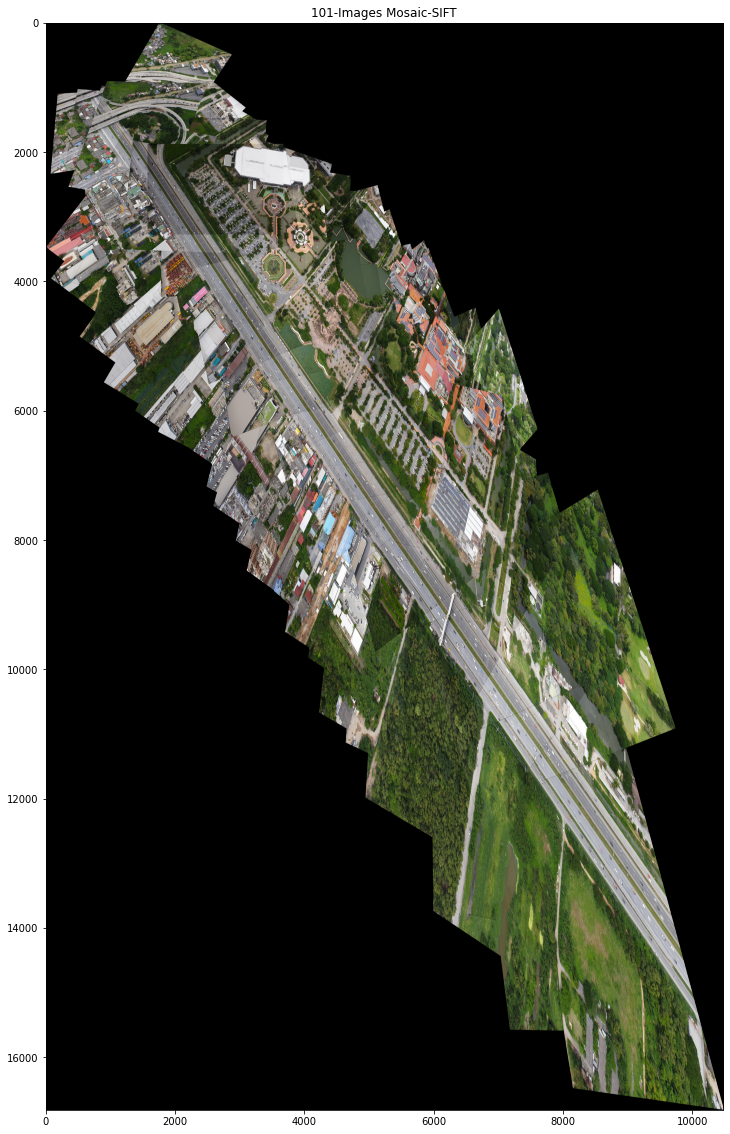

In [ ]:
fig,ax =plt.subplots()
fig.set_size_inches(20,20)
ax.imshow(cv2.cvtColor(warp_imgs_all_sift , cv2.COLOR_BGR2RGB))
ax.set_title('101-Images Mosaic-SIFT')

In [ ]:
akaze = cv2.AKAZE_create()


keypoints_all_left_akaze = []
descriptors_all_left_akaze = []
points_all_left_akaze=[]

keypoints_all_right_akaze = []
descriptors_all_right_akaze = []
points_all_right_akaze=[]

for imgs in tqdm(images_left_bgr):
  kpt = akaze.detect(imgs,None)
  kpt,descrip =  akaze.compute(imgs, kpt)
  keypoints_all_left_akaze.append(kpt)
  descriptors_all_left_akaze.append(descrip)
  points_all_left_akaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for imgs in tqdm(images_right_bgr):
  kpt = akaze.detect(imgs,None)
  kpt,descrip =  akaze.compute(imgs, kpt)
  keypoints_all_right_akaze.append(kpt)
  descriptors_all_right_akaze.append(descrip)
  points_all_right_akaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

100%|██████████| 51/51 [01:23<00:00,  1.64s/it]


In [ ]:
def compute_homography_fast(matched_pts1, matched_pts2,thresh=4):
    #matched_pts1 = cv2.KeyPoint_convert(matched_kp1)
    #matched_pts2 = cv2.KeyPoint_convert(matched_kp2)

    # Estimate the homography between the matches using RANSAC
    H, inliers = cv2.findHomography(matched_pts1,
                                    matched_pts2,
                                    cv2.RANSAC, ransacReprojThreshold =thresh)
    inliers = inliers.flatten()
    return H, inliers

In [ ]:
def compute_homography_fast_other(matched_pts1, matched_pts2):
    #matched_pts1 = cv2.KeyPoint_convert(matched_kp1)
    #matched_pts2 = cv2.KeyPoint_convert(matched_kp2)

    # Estimate the homography between the matches using RANSAC
    H, inliers = cv2.findHomography(matched_pts1,
                                    matched_pts2,
                                    0)
    inliers = inliers.flatten()
    return H, inliers

In [ ]:
def get_Hmatrix(imgs,keypts,pts,descripts,ratio=0.9,thresh=4,disp=False):
  FLANN_INDEX_KDTREE = 2
  index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
  search_params = dict(checks=50)
  flann = cv2.FlannBasedMatcher(index_params, search_params)
  #flann = cv2.BFMatcher()

  lff1 = np.float32(descripts[0])
  lff = np.float32(descripts[1])


  matches_lf1_lf = flann.knnMatch(lff1, lff, k=2)

  print("\nNumber of matches",len(matches_lf1_lf))

  matches_4 = []
  ratio = ratio
  # loop over the raw matches
  for m in matches_lf1_lf:
    # ensure the distance is within a certain ratio of each
    # other (i.e. Lowe’s ratio test)
    if len(m) == 2 and m[0].distance < m[1].distance * ratio:
        #matches_1.append((m[0].trainIdx, m[0].queryIdx))
        matches_4.append(m[0])

  print("Number of matches After Lowe's Ratio",len(matches_4))
  
  matches_idx = np.array([m.queryIdx for m in matches_4])
  imm1_pts = np.array([keypts[0][idx].pt for idx in matches_idx])
  matches_idx = np.array([m.trainIdx for m in matches_4])
  imm2_pts = np.array([keypts[1][idx].pt for idx in matches_idx])
  '''
  # Estimate homography 1
  #Compute H1
  # Estimate homography 1
  #Compute H1
  imm1_pts=np.empty((len(matches_4),2))
  imm2_pts=np.empty((len(matches_4),2))
  for i in range(0,len(matches_4)):
    m = matches_4[i]
    (a_x, a_y) = keypts[0][m.queryIdx].pt
    (b_x, b_y) = keypts[1][m.trainIdx].pt
    imm1_pts[i]=(a_x, a_y)
    imm2_pts[i]=(b_x, b_y)    
  H=compute_Homography(imm1_pts,imm2_pts) 
  #Robustly estimate Homography 1 using RANSAC
  Hn, best_inliers=RANSAC_alg(keypts[0] ,keypts[1], matches_4,  nRANSAC=1000, RANSACthresh=6)
  '''
  
  
  Hn,inliers = compute_homography_fast(imm1_pts,imm2_pts,thresh)  
  inlier_matchset = np.array(matches_4)[inliers.astype(bool)].tolist()
  print("Number of Robust matches",len(inlier_matchset))
  print("\n")
  '''
  if len(inlier_matchset)<50:
    matches_4 = []
    ratio = 0.67
    # loop over the raw matches
    for m in matches_lf1_lf:
      # ensure the distance is within a certain ratio of each
      # other (i.e. Lowe’s ratio test)
      if len(m) == 2 and m[0].distance < m[1].distance * ratio:
          #matches_1.append((m[0].trainIdx, m[0].queryIdx))
          matches_4.append(m[0])
    print("Number of matches After Lowe's Ratio New",len(matches_4))
  
    matches_idx = np.array([m.queryIdx for m in matches_4])
    imm1_pts = np.array([keypts[0][idx].pt for idx in matches_idx])
    matches_idx = np.array([m.trainIdx for m in matches_4])
    imm2_pts = np.array([keypts[1][idx].pt for idx in matches_idx])
    Hn,inliers = compute_homography_fast_other(imm1_pts,imm2_pts)  
    inlier_matchset = np.array(matches_4)[inliers.astype(bool)].tolist()
    print("Number of Robust matches New",len(inlier_matchset))
    print("\n")    
    '''
  #H=compute_Homography(imm1_pts,imm2_pts) 
  #Robustly estimate Homography 1 using RANSAC
  #Hn=RANSAC_alg(keypts[0] ,keypts[1], matches_4,  nRANSAC=1500, RANSACthresh=6)

  #global inlier_matchset   
  
  if disp==True:
    dispimg1=cv2.drawMatches(imgs[0], keypts[0], imgs[1], keypts[1], inlier_matchset, None,flags=2)
    displayplot(dispimg1,'Robust Matching between Reference Image and Right Image ')
  
  return Hn/Hn[2,2], len(matches_lf1_lf), len(inlier_matchset)

In [ ]:
from functools import partial
from tqdm import tqdm
tqdm = partial(tqdm, position=0, leave=True)

In [ ]:
print(left_files_path)

['/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0051.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0050.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0049.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0048.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0047.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0046.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0045.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0044.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0043.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0042.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0041.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0040.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0039.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0038.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0037.JPG', '/content/drive/MyDrive/RGB-img/img/IX-

In [ ]:

print(right_files_path)

['/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0051.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0052.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0053.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0054.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0055.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0056.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0057.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0058.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0059.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0060.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0061.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0062.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0063.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0064.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0065.JPG', '/content/drive/MyDrive/RGB-img/img/IX-

In [ ]:
H_left_akaze = []
H_right_akaze = []

num_matches_akaze = []
num_good_matches_akaze = []

for j in tqdm(range(len(images_left))):
  if j==len(images_left)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_akaze[j:j+2][::-1],points_all_left_akaze[j:j+2][::-1],descriptors_all_left_akaze[j:j+2][::-1])
  H_left_akaze.append(H_a)
  num_matches_akaze.append(matches)
  num_good_matches_akaze.append(gd_matches)

for j in tqdm(range(len(images_right))):
  if j==len(images_right)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_akaze[j:j+2][::-1],points_all_right_akaze[j:j+2][::-1],descriptors_all_right_akaze[j:j+2][::-1])
  H_right_akaze.append(H_a)
  #num_matches.append(matches)
  #num_good_matches.append(gd_matches)

  2%|▏         | 1/51 [00:01<01:10,  1.40s/it]


Number of matches 20465
Number of matches After Lowe's Ratio 5478
Number of Robust matches 2272




  4%|▍         | 2/51 [00:03<01:14,  1.52s/it]


Number of matches 19280
Number of matches After Lowe's Ratio 5752
Number of Robust matches 2529




  6%|▌         | 3/51 [00:04<01:16,  1.58s/it]


Number of matches 21349
Number of matches After Lowe's Ratio 6103
Number of Robust matches 2511




  8%|▊         | 4/51 [00:06<01:20,  1.71s/it]


Number of matches 21345
Number of matches After Lowe's Ratio 7421
Number of Robust matches 3932




 10%|▉         | 5/51 [00:08<01:22,  1.80s/it]


Number of matches 20541
Number of matches After Lowe's Ratio 6447
Number of Robust matches 2898




 12%|█▏        | 6/51 [00:10<01:23,  1.86s/it]


Number of matches 19544
Number of matches After Lowe's Ratio 6479
Number of Robust matches 3432




 14%|█▎        | 7/51 [00:12<01:20,  1.84s/it]


Number of matches 19557
Number of matches After Lowe's Ratio 6319
Number of Robust matches 3039




 16%|█▌        | 8/51 [00:14<01:19,  1.85s/it]


Number of matches 19398
Number of matches After Lowe's Ratio 6957
Number of Robust matches 3898




 18%|█▊        | 9/51 [00:16<01:17,  1.84s/it]


Number of matches 19838
Number of matches After Lowe's Ratio 7437
Number of Robust matches 4108




 20%|█▉        | 10/51 [00:18<01:14,  1.82s/it]


Number of matches 19744
Number of matches After Lowe's Ratio 6970
Number of Robust matches 3521




 22%|██▏       | 11/51 [00:20<01:14,  1.86s/it]


Number of matches 20624
Number of matches After Lowe's Ratio 6542
Number of Robust matches 2825




 24%|██▎       | 12/51 [00:22<01:12,  1.86s/it]


Number of matches 19950
Number of matches After Lowe's Ratio 6270
Number of Robust matches 2707




 25%|██▌       | 13/51 [00:23<01:10,  1.86s/it]


Number of matches 20566
Number of matches After Lowe's Ratio 6203
Number of Robust matches 2584




 27%|██▋       | 14/51 [00:25<01:10,  1.90s/it]


Number of matches 20559
Number of matches After Lowe's Ratio 5745
Number of Robust matches 2136




 29%|██▉       | 15/51 [00:27<01:09,  1.94s/it]


Number of matches 24258
Number of matches After Lowe's Ratio 5957
Number of Robust matches 1412




 31%|███▏      | 16/51 [00:30<01:11,  2.05s/it]


Number of matches 20958
Number of matches After Lowe's Ratio 5350
Number of Robust matches 1278




 33%|███▎      | 17/51 [00:32<01:10,  2.08s/it]


Number of matches 22246
Number of matches After Lowe's Ratio 5880
Number of Robust matches 1482




 35%|███▌      | 18/51 [00:34<01:09,  2.09s/it]


Number of matches 20947
Number of matches After Lowe's Ratio 5516
Number of Robust matches 1373




 37%|███▋      | 19/51 [00:36<01:06,  2.09s/it]


Number of matches 24081
Number of matches After Lowe's Ratio 5061
Number of Robust matches 904




 39%|███▉      | 20/51 [00:38<01:07,  2.17s/it]


Number of matches 22618
Number of matches After Lowe's Ratio 5206
Number of Robust matches 1139




 41%|████      | 21/51 [00:41<01:06,  2.21s/it]


Number of matches 23539
Number of matches After Lowe's Ratio 4559
Number of Robust matches 408




 43%|████▎     | 22/51 [00:43<01:03,  2.20s/it]


Number of matches 19832
Number of matches After Lowe's Ratio 3491
Number of Robust matches 7




 45%|████▌     | 23/51 [00:45<00:58,  2.07s/it]


Number of matches 19393
Number of matches After Lowe's Ratio 4861
Number of Robust matches 1472




 47%|████▋     | 24/51 [00:46<00:53,  1.97s/it]


Number of matches 17976
Number of matches After Lowe's Ratio 4851
Number of Robust matches 1752




 49%|████▉     | 25/51 [00:48<00:49,  1.90s/it]


Number of matches 19408
Number of matches After Lowe's Ratio 4978
Number of Robust matches 1769




 51%|█████     | 26/51 [00:50<00:47,  1.89s/it]


Number of matches 23039
Number of matches After Lowe's Ratio 5903
Number of Robust matches 1828




 53%|█████▎    | 27/51 [00:52<00:48,  2.03s/it]


Number of matches 26557
Number of matches After Lowe's Ratio 5750
Number of Robust matches 1102




 55%|█████▍    | 28/51 [00:55<00:52,  2.30s/it]


Number of matches 28674
Number of matches After Lowe's Ratio 6817
Number of Robust matches 1197




 57%|█████▋    | 29/51 [00:58<00:54,  2.50s/it]


Number of matches 25251
Number of matches After Lowe's Ratio 6293
Number of Robust matches 1591




 59%|█████▉    | 30/51 [01:01<00:52,  2.51s/it]


Number of matches 22062
Number of matches After Lowe's Ratio 6092
Number of Robust matches 1745




 61%|██████    | 31/51 [01:03<00:47,  2.36s/it]


Number of matches 20521
Number of matches After Lowe's Ratio 6016
Number of Robust matches 2281




 63%|██████▎   | 32/51 [01:05<00:42,  2.22s/it]


Number of matches 19126
Number of matches After Lowe's Ratio 5972
Number of Robust matches 2366




 65%|██████▍   | 33/51 [01:06<00:37,  2.08s/it]


Number of matches 20186
Number of matches After Lowe's Ratio 6728
Number of Robust matches 3287




 67%|██████▋   | 34/51 [01:08<00:35,  2.07s/it]


Number of matches 21213
Number of matches After Lowe's Ratio 6544
Number of Robust matches 3013




 69%|██████▊   | 35/51 [01:10<00:32,  2.05s/it]


Number of matches 21932
Number of matches After Lowe's Ratio 7019
Number of Robust matches 3131




 71%|███████   | 36/51 [01:13<00:30,  2.05s/it]


Number of matches 21264
Number of matches After Lowe's Ratio 7108
Number of Robust matches 3515




 73%|███████▎  | 37/51 [01:15<00:28,  2.06s/it]


Number of matches 20833
Number of matches After Lowe's Ratio 6510
Number of Robust matches 2858




 75%|███████▍  | 38/51 [01:17<00:26,  2.02s/it]


Number of matches 18699
Number of matches After Lowe's Ratio 4905
Number of Robust matches 1816




 76%|███████▋  | 39/51 [01:18<00:23,  1.92s/it]


Number of matches 17733
Number of matches After Lowe's Ratio 6362
Number of Robust matches 3591




 78%|███████▊  | 40/51 [01:20<00:20,  1.86s/it]


Number of matches 18293
Number of matches After Lowe's Ratio 6383
Number of Robust matches 3604




 80%|████████  | 41/51 [01:22<00:17,  1.79s/it]


Number of matches 16473
Number of matches After Lowe's Ratio 4553
Number of Robust matches 1963




 82%|████████▏ | 42/51 [01:23<00:15,  1.69s/it]


Number of matches 17759
Number of matches After Lowe's Ratio 4898
Number of Robust matches 2057




 84%|████████▍ | 43/51 [01:25<00:13,  1.66s/it]


Number of matches 18253
Number of matches After Lowe's Ratio 5708
Number of Robust matches 2772




 86%|████████▋ | 44/51 [01:26<00:11,  1.69s/it]


Number of matches 18717
Number of matches After Lowe's Ratio 4842
Number of Robust matches 1782




 88%|████████▊ | 45/51 [01:28<00:10,  1.70s/it]


Number of matches 18943
Number of matches After Lowe's Ratio 5284
Number of Robust matches 2150




 90%|█████████ | 46/51 [01:30<00:08,  1.70s/it]


Number of matches 18446
Number of matches After Lowe's Ratio 4968
Number of Robust matches 1576




 92%|█████████▏| 47/51 [01:31<00:06,  1.69s/it]


Number of matches 19154
Number of matches After Lowe's Ratio 5649
Number of Robust matches 1989




 94%|█████████▍| 48/51 [01:33<00:05,  1.77s/it]


Number of matches 20674
Number of matches After Lowe's Ratio 4890
Number of Robust matches 996




 96%|█████████▌| 49/51 [01:35<00:03,  1.84s/it]


Number of matches 20317
Number of matches After Lowe's Ratio 5355
Number of Robust matches 1080




  0%|          | 0/51 [00:00<?, ?it/s]


Number of matches 17535
Number of matches After Lowe's Ratio 3512
Number of Robust matches 104




  2%|▏         | 1/51 [00:01<01:14,  1.49s/it]


Number of matches 21469
Number of matches After Lowe's Ratio 4339
Number of Robust matches 1103




  4%|▍         | 2/51 [00:03<01:18,  1.60s/it]


Number of matches 15748
Number of matches After Lowe's Ratio 4509
Number of Robust matches 1804




  6%|▌         | 3/51 [00:04<01:12,  1.51s/it]


Number of matches 20428
Number of matches After Lowe's Ratio 4153
Number of Robust matches 1061




  8%|▊         | 4/51 [00:06<01:15,  1.61s/it]


Number of matches 19049
Number of matches After Lowe's Ratio 5497
Number of Robust matches 2157




 10%|▉         | 5/51 [00:08<01:18,  1.70s/it]


Number of matches 18754
Number of matches After Lowe's Ratio 5243
Number of Robust matches 1699




 12%|█▏        | 6/51 [00:10<01:16,  1.70s/it]


Number of matches 18110
Number of matches After Lowe's Ratio 5098
Number of Robust matches 1682




 14%|█▎        | 7/51 [00:11<01:14,  1.68s/it]


Number of matches 18547
Number of matches After Lowe's Ratio 5152
Number of Robust matches 1612




 16%|█▌        | 8/51 [00:13<01:14,  1.72s/it]


Number of matches 21720
Number of matches After Lowe's Ratio 3607
Number of Robust matches 8




 18%|█▊        | 9/51 [00:15<01:16,  1.82s/it]


Number of matches 16167
Number of matches After Lowe's Ratio 3405
Number of Robust matches 401




 20%|█▉        | 10/51 [00:16<01:08,  1.66s/it]


Number of matches 16819
Number of matches After Lowe's Ratio 3465
Number of Robust matches 623




 22%|██▏       | 11/51 [00:18<01:05,  1.63s/it]


Number of matches 18233
Number of matches After Lowe's Ratio 4173
Number of Robust matches 1067




 24%|██▎       | 12/51 [00:20<01:04,  1.66s/it]


Number of matches 20771
Number of matches After Lowe's Ratio 5737
Number of Robust matches 2328




 25%|██▌       | 13/51 [00:22<01:07,  1.77s/it]


Number of matches 18297
Number of matches After Lowe's Ratio 5721
Number of Robust matches 2389




 27%|██▋       | 14/51 [00:23<01:03,  1.72s/it]


Number of matches 15660
Number of matches After Lowe's Ratio 3784
Number of Robust matches 1178




 29%|██▉       | 15/51 [00:25<00:57,  1.61s/it]


Number of matches 19968
Number of matches After Lowe's Ratio 3564
Number of Robust matches 258




 31%|███▏      | 16/51 [00:26<00:57,  1.65s/it]


Number of matches 15728
Number of matches After Lowe's Ratio 4667
Number of Robust matches 1941




 33%|███▎      | 17/51 [00:28<00:52,  1.55s/it]


Number of matches 21692
Number of matches After Lowe's Ratio 4971
Number of Robust matches 1551




 35%|███▌      | 18/51 [00:30<00:57,  1.75s/it]


Number of matches 21865
Number of matches After Lowe's Ratio 7491
Number of Robust matches 3297




 37%|███▋      | 19/51 [00:32<00:59,  1.86s/it]


Number of matches 21455
Number of matches After Lowe's Ratio 8264
Number of Robust matches 4441




 39%|███▉      | 20/51 [00:34<00:59,  1.90s/it]


Number of matches 19571
Number of matches After Lowe's Ratio 6927
Number of Robust matches 4005




 41%|████      | 21/51 [00:36<00:57,  1.93s/it]


Number of matches 20134
Number of matches After Lowe's Ratio 6994
Number of Robust matches 3874




 43%|████▎     | 22/51 [00:38<00:55,  1.92s/it]


Number of matches 21099
Number of matches After Lowe's Ratio 6124
Number of Robust matches 2709




 45%|████▌     | 23/51 [00:40<00:54,  1.96s/it]


Number of matches 22136
Number of matches After Lowe's Ratio 7018
Number of Robust matches 3032




 47%|████▋     | 24/51 [00:42<00:55,  2.06s/it]


Number of matches 23198
Number of matches After Lowe's Ratio 6654
Number of Robust matches 2337




 49%|████▉     | 25/51 [00:45<00:55,  2.13s/it]


Number of matches 24310
Number of matches After Lowe's Ratio 6872
Number of Robust matches 2438




 51%|█████     | 26/51 [00:47<00:56,  2.26s/it]


Number of matches 24654
Number of matches After Lowe's Ratio 7246
Number of Robust matches 2253




 53%|█████▎    | 27/51 [00:50<00:55,  2.31s/it]


Number of matches 22984
Number of matches After Lowe's Ratio 7028
Number of Robust matches 2164




 55%|█████▍    | 28/51 [00:52<00:52,  2.28s/it]


Number of matches 21716
Number of matches After Lowe's Ratio 6315
Number of Robust matches 1731




 57%|█████▋    | 29/51 [00:54<00:50,  2.29s/it]


Number of matches 22411
Number of matches After Lowe's Ratio 7102
Number of Robust matches 2097




 59%|█████▉    | 30/51 [00:56<00:47,  2.26s/it]


Number of matches 20504
Number of matches After Lowe's Ratio 6077
Number of Robust matches 1635




 61%|██████    | 31/51 [00:58<00:43,  2.16s/it]


Number of matches 20204
Number of matches After Lowe's Ratio 5819
Number of Robust matches 1622




 63%|██████▎   | 32/51 [01:00<00:39,  2.09s/it]


Number of matches 20233
Number of matches After Lowe's Ratio 5502
Number of Robust matches 1661




 65%|██████▍   | 33/51 [01:02<00:38,  2.15s/it]


Number of matches 27287
Number of matches After Lowe's Ratio 4657
Number of Robust matches 74




 67%|██████▋   | 34/51 [01:05<00:40,  2.36s/it]


Number of matches 25609
Number of matches After Lowe's Ratio 5193
Number of Robust matches 445



Number of matches 29338
Number of matches After Lowe's Ratio 4834


 69%|██████▊   | 35/51 [01:08<00:40,  2.52s/it]

Number of Robust matches 8




 71%|███████   | 36/51 [01:11<00:40,  2.69s/it]


Number of matches 24561
Number of matches After Lowe's Ratio 5102
Number of Robust matches 625




 73%|███████▎  | 37/51 [01:14<00:36,  2.62s/it]


Number of matches 22164
Number of matches After Lowe's Ratio 5985
Number of Robust matches 1444




 75%|███████▍  | 38/51 [01:16<00:32,  2.47s/it]


Number of matches 20348
Number of matches After Lowe's Ratio 5528
Number of Robust matches 1280




 76%|███████▋  | 39/51 [01:18<00:28,  2.35s/it]


Number of matches 19519
Number of matches After Lowe's Ratio 5085
Number of Robust matches 1066




 78%|███████▊  | 40/51 [01:20<00:24,  2.22s/it]


Number of matches 20911
Number of matches After Lowe's Ratio 5214
Number of Robust matches 886




 80%|████████  | 41/51 [01:22<00:21,  2.16s/it]


Number of matches 20565
Number of matches After Lowe's Ratio 4949
Number of Robust matches 1024




 82%|████████▏ | 42/51 [01:24<00:19,  2.14s/it]


Number of matches 20347
Number of matches After Lowe's Ratio 6676
Number of Robust matches 1990




 84%|████████▍ | 43/51 [01:26<00:16,  2.12s/it]


Number of matches 22441
Number of matches After Lowe's Ratio 5294
Number of Robust matches 1164




 86%|████████▋ | 44/51 [01:28<00:15,  2.15s/it]


Number of matches 21870
Number of matches After Lowe's Ratio 6864
Number of Robust matches 2103




 88%|████████▊ | 45/51 [01:30<00:13,  2.17s/it]


Number of matches 20671
Number of matches After Lowe's Ratio 5737
Number of Robust matches 1628




 90%|█████████ | 46/51 [01:33<00:10,  2.12s/it]


Number of matches 18732
Number of matches After Lowe's Ratio 5352
Number of Robust matches 1863




 92%|█████████▏| 47/51 [01:34<00:08,  2.01s/it]


Number of matches 18770
Number of matches After Lowe's Ratio 4657
Number of Robust matches 1701




 94%|█████████▍| 48/51 [01:36<00:05,  1.92s/it]


Number of matches 18471
Number of matches After Lowe's Ratio 4908
Number of Robust matches 1833




 96%|█████████▌| 49/51 [01:38<00:03,  1.88s/it]


Number of matches 17991
Number of matches After Lowe's Ratio 4927
Number of Robust matches 1814




 98%|█████████▊| 50/51 [01:39<00:01,  1.80s/it]


Number of matches 17772
Number of matches After Lowe's Ratio 6270
Number of Robust matches 3355




In [ ]:
def warpnImages(images_left, images_right,H_left,H_right):
    #img1-centre,img2-left,img3-right

    h, w = images_left[0].shape[:2]

    pts_left = []
    pts_right = []

    pts_centre = np.float32([[0, 0], [0, h], [w, h], [w, 0]]).reshape(-1, 1, 2)

    for j in range(len(H_left)):
      pts = np.float32([[0, 0], [0, h], [w, h], [w, 0]]).reshape(-1, 1, 2)
      pts_left.append(pts)

    for j in range(len(H_right)):
      pts = np.float32([[0, 0], [0, h], [w, h], [w, 0]]).reshape(-1, 1, 2)
      pts_right.append(pts)

    pts_left_transformed=[]
    pts_right_transformed=[]



    for j,pts in enumerate(pts_left):
      if j==0:
        H_trans = H_left[j]
      else:
        H_trans = H_trans@H_left[j]
      pts_ = cv2.perspectiveTransform(pts, H_trans)
      pts_left_transformed.append(pts_)

    for j,pts in enumerate(pts_right):
      if j==0:
        H_trans = H_right[j]
      else:
        H_trans = H_trans@H_right[j]
      pts_ = cv2.perspectiveTransform(pts, H_trans)
      pts_right_transformed.append(pts_)


    print('Step1:Done')


    #pts = np.concatenate((pts1, pts2_), axis=0)

    pts_concat = np.concatenate((pts_centre,np.concatenate(np.array(pts_left_transformed),axis=0),np.concatenate(np.array(pts_right_transformed),axis=0)), axis=0)

    [xmin, ymin] = np.int32(pts_concat.min(axis=0).ravel() - 0.5)
    [xmax, ymax] = np.int32(pts_concat.max(axis=0).ravel() + 0.5)
    t = [-xmin, -ymin]
    Ht = np.array([[1, 0, t[0]], [0, 1, t[1]], [0, 0, 1]])  # translate

    print('Step2:Done')


    return xmax,xmin,ymax,ymin,t,h,w,Ht

In [ ]:
def final_steps_left(images_left,images_right,H_left,H_right,xmax,xmin,ymax,ymin,t,h,w,Ht):

    warp_imgs_left = []


    for j,H in enumerate(H_left):
      if j==0:
        H_trans = Ht@H
      else:
        H_trans = H_trans@H
      result = cv2.warpPerspective(images_left[j+1], H_trans, (xmax-xmin, ymax-ymin))

      if j==0:
        result[t[1]:h+t[1], t[0]:w+t[0]] = images_left[0]
      
      warp_imgs_left.append(result)

    print('Step31:Done')

    return warp_imgs_left

def final_steps_right(images_left,images_right,H_left,H_right,xmax,xmin,ymax,ymin,t,h,w,Ht):

    warp_imgs_right = []

    for j,H in enumerate(H_right):
      if j==0:
        H_trans = Ht@H
      else:
        H_trans = H_trans@H
      result = cv2.warpPerspective(images_right[j+1], H_trans, (xmax-xmin, ymax-ymin))
      
      warp_imgs_right.append(result)

    print('Step32:Done')

    return warp_imgs_right

def final_steps_union(warp_imgs_left,warp_imgs_right):
    #Union

    warp_images_all = warp_imgs_left + warp_imgs_right

    warp_img_init = warp_images_all[0]



    #warp_final_all=[]

    for j,warp_img in enumerate(warp_images_all):
      if j==len(warp_images_all)-1:
        break
      black_pixels = np.where((warp_img_init[:, :, 0] == 0) & (warp_img_init[:, :, 1] == 0) & (warp_img_init[:, :, 2] == 0))

      warp_img_init[black_pixels] = warp_images_all[j+1][black_pixels]
    
      #warp_final = np.maximum(warp_img_init,warp_images_all[j+1])
      #warp_img_init = warp_final
      #warp_final_all.append(warp_final)

    print('Step4:Done')


    return warp_img_init

In [ ]:
def final_steps_left_union(images_left,H_left,xmax,xmin,ymax,ymin,t,h,w,Ht):



    for j,H in enumerate(H_left):
      if j==0:
        H_trans = Ht@H
      else:
        H_trans = H_trans@H
      input_img = images_left[j+1]
      result = np.zeros((ymax-ymin,xmax-xmin,3),dtype='uint8')

      cv2.warpPerspective(src = np.uint8(input_img), M = H_trans, dsize = (xmax-xmin, ymax-ymin),dst=result)
      warp_img_init_curr = result

      if j==0:
        result[t[1]:h+t[1], t[0]:w+t[0]] = images_left[0]
        warp_img_init_prev = result
        continue

      black_pixels = np.where((warp_img_init_prev[:, :, 0] == 0) & (warp_img_init_prev[:, :, 1] == 0) & (warp_img_init_prev[:, :, 2] == 0))

      warp_img_init_prev[black_pixels] = warp_img_init_curr[black_pixels]

    print('Step31:Done')

    return warp_img_init_prev

def final_steps_right_union(warp_img_prev,images_right,H_right,xmax,xmin,ymax,ymin,t,h,w,Ht):

    for j,H in enumerate(H_right):
      if j==0:
        H_trans = Ht@H
      else:
        H_trans = H_trans@H
      input_img = images_right[j+1]
      result = np.zeros((ymax-ymin,xmax-xmin,3),dtype='uint8')

      cv2.warpPerspective(src = np.uint8(input_img), M = H_trans, dsize = (xmax-xmin, ymax-ymin),dst=result)
      warp_img_init_curr = result

      black_pixels = np.where((warp_img_prev[:, :, 0] == 0) & (warp_img_prev[:, :, 1] == 0) & (warp_img_prev[:, :, 2] == 0))

      warp_img_prev[black_pixels] = warp_img_init_curr[black_pixels]

    print('Step32:Done')

    return warp_img_prev

In [ ]:
xmax,xmin,ymax,ymin,t,h,w,Ht = warpnImages(images_left_bgr_no_enhance, images_right_bgr_no_enhance,H_left_akaze,H_right_akaze)

Step1:Done
Step2:Done


In [ ]:
warp_imgs_left = final_steps_left_union(images_left_bgr_no_enhance,H_left_akaze,xmax,xmin,ymax,ymin,t,h,w,Ht)

Step31:Done


In [ ]:
warp_imgs_all_akaze = final_steps_right_union(warp_imgs_left,images_right_bgr_no_enhance,H_right_akaze,xmax,xmin,ymax,ymin,t,h,w,Ht)

Step32:Done


Text(0.5, 1.0, '101-Images Mosaic-AKAZE')

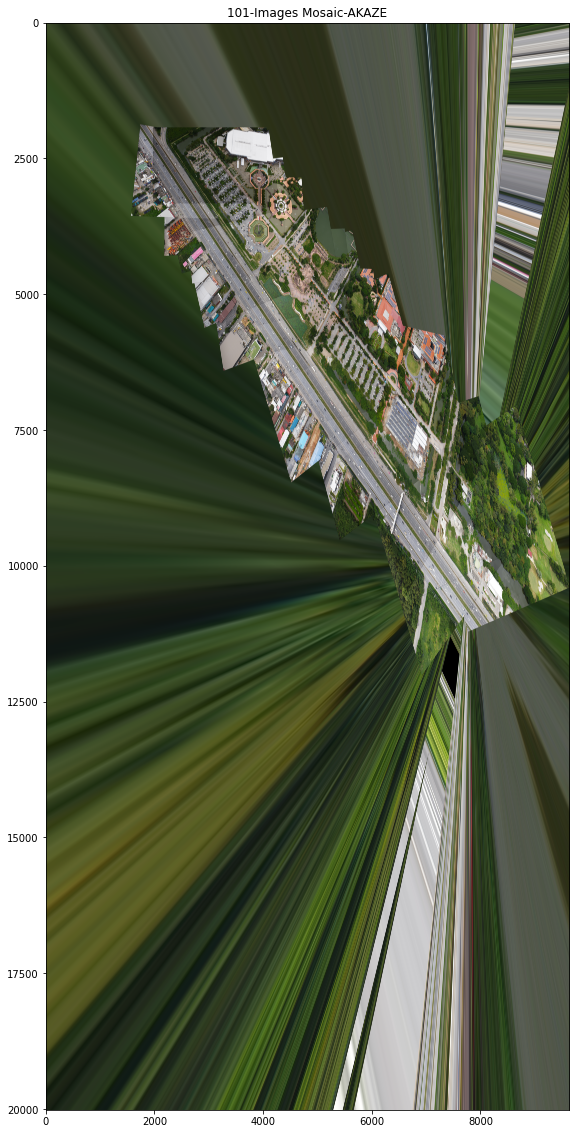

In [ ]:
fig,ax =plt.subplots()
fig.set_size_inches(20,20)
ax.imshow(cv2.cvtColor(warp_imgs_all_akaze , cv2.COLOR_BGR2RGB))
ax.set_title('101-Images Mosaic-AKAZE')

In [25]:
Threshl=60;
Octaves=8; 
#PatternScales=1.0f;
brisk = cv2.BRISK_create(Threshl,Octaves)


keypoints_all_left_brisk = []
descriptors_all_left_brisk = []
points_all_left_brisk=[]

keypoints_all_right_brisk = []
descriptors_all_right_brisk = []
points_all_right_brisk=[]

for imgs in tqdm(images_left_bgr):
  kpt = brisk.detect(imgs,None)
  kpt,descrip =  brisk.compute(imgs, kpt)
  keypoints_all_left_brisk.append(kpt)
  descriptors_all_left_brisk.append(descrip)
  points_all_left_brisk.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for imgs in tqdm(images_right_bgr):
  kpt = brisk.detect(imgs,None)
  kpt,descrip =  brisk.compute(imgs, kpt)
  keypoints_all_right_brisk.append(kpt)
  descriptors_all_right_brisk.append(descrip)
  points_all_right_brisk.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

100%|██████████| 51/51 [00:54<00:00,  1.06s/it]


In [26]:
def compute_homography_fast(matched_pts1, matched_pts2,thresh=4):
    #matched_pts1 = cv2.KeyPoint_convert(matched_kp1)
    #matched_pts2 = cv2.KeyPoint_convert(matched_kp2)

    # Estimate the homography between the matches using RANSAC
    H, inliers = cv2.findHomography(matched_pts1,
                                    matched_pts2,
                                    cv2.RANSAC, ransacReprojThreshold =thresh)
    inliers = inliers.flatten()
    return H, inliers

In [27]:
def compute_homography_fast_other(matched_pts1, matched_pts2):
    #matched_pts1 = cv2.KeyPoint_convert(matched_kp1)
    #matched_pts2 = cv2.KeyPoint_convert(matched_kp2)

    # Estimate the homography between the matches using RANSAC
    H, inliers = cv2.findHomography(matched_pts1,
                                    matched_pts2,
                                    0)
    inliers = inliers.flatten()
    return H, inliers

In [32]:
def get_Hmatrix(imgs,keypts,pts,descripts,ratio=0.9,thresh=4,disp=False):
  FLANN_INDEX_KDTREE = 2
  index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
  search_params = dict(checks=50)
  flann = cv2.FlannBasedMatcher(index_params, search_params)
  #flann = cv2.BFMatcher()

  lff1 = np.float32(descripts[0])
  lff = np.float32(descripts[1])


  matches_lf1_lf = flann.knnMatch(lff1, lff, k=2)

  print("\nNumber of matches",len(matches_lf1_lf))

  matches_4 = []
  ratio = ratio
  # loop over the raw matches
  for m in matches_lf1_lf:
    # ensure the distance is within a certain ratio of each
    # other (i.e. Lowe’s ratio test)
    if len(m) == 2 and m[0].distance < m[1].distance * ratio:
        #matches_1.append((m[0].trainIdx, m[0].queryIdx))
        matches_4.append(m[0])

  print("Number of matches After Lowe's Ratio",len(matches_4))
  
  matches_idx = np.array([m.queryIdx for m in matches_4])
  imm1_pts = np.array([keypts[0][idx].pt for idx in matches_idx])
  matches_idx = np.array([m.trainIdx for m in matches_4])
  imm2_pts = np.array([keypts[1][idx].pt for idx in matches_idx])
  '''
  # Estimate homography 1
  #Compute H1
  # Estimate homography 1
  #Compute H1
  imm1_pts=np.empty((len(matches_4),2))
  imm2_pts=np.empty((len(matches_4),2))
  for i in range(0,len(matches_4)):
    m = matches_4[i]
    (a_x, a_y) = keypts[0][m.queryIdx].pt
    (b_x, b_y) = keypts[1][m.trainIdx].pt
    imm1_pts[i]=(a_x, a_y)
    imm2_pts[i]=(b_x, b_y)    
  H=compute_Homography(imm1_pts,imm2_pts) 
  #Robustly estimate Homography 1 using RANSAC
  Hn, best_inliers=RANSAC_alg(keypts[0] ,keypts[1], matches_4,  nRANSAC=1000, RANSACthresh=6)
  '''
  
  
  Hn,inliers = compute_homography_fast(imm1_pts,imm2_pts,thresh)  
  inlier_matchset = np.array(matches_4)[inliers.astype(bool)].tolist()
  print("Number of Robust matches",len(inlier_matchset))
  print("\n")
  '''
  if len(inlier_matchset)<50:
    matches_4 = []
    ratio = 0.67
    # loop over the raw matches
    for m in matches_lf1_lf:
      # ensure the distance is within a certain ratio of each
      # other (i.e. Lowe’s ratio test)
      if len(m) == 2 and m[0].distance < m[1].distance * ratio:
          #matches_1.append((m[0].trainIdx, m[0].queryIdx))
          matches_4.append(m[0])
    print("Number of matches After Lowe's Ratio New",len(matches_4))
  
    matches_idx = np.array([m.queryIdx for m in matches_4])
    imm1_pts = np.array([keypts[0][idx].pt for idx in matches_idx])
    matches_idx = np.array([m.trainIdx for m in matches_4])
    imm2_pts = np.array([keypts[1][idx].pt for idx in matches_idx])
    Hn,inliers = compute_homography_fast_other(imm1_pts,imm2_pts)  
    inlier_matchset = np.array(matches_4)[inliers.astype(bool)].tolist()
    print("Number of Robust matches New",len(inlier_matchset))
    print("\n")    
    '''
  #H=compute_Homography(imm1_pts,imm2_pts) 
  #Robustly estimate Homography 1 using RANSAC
  #Hn=RANSAC_alg(keypts[0] ,keypts[1], matches_4,  nRANSAC=1500, RANSACthresh=6)

  #global inlier_matchset   
  
  if disp==True:
    dispimg1=cv2.drawMatches(imgs[0], keypts[0], imgs[1], keypts[1], inlier_matchset, None,flags=2)
    displayplot(dispimg1,'Robust Matching between Reference Image and Right Image ')
  
  return Hn/Hn[2,2], len(matches_lf1_lf), len(inlier_matchset)

In [33]:
from functools import partial
from tqdm import tqdm
tqdm = partial(tqdm, position=0, leave=True)

In [34]:
print(left_files_path)

['/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0051.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0050.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0049.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0048.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0047.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0046.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0045.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0044.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0043.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0042.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0041.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0040.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0039.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0038.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0037.JPG', '/content/drive/MyDrive/RGB-img/img/IX-

In [35]:
print(right_files_path)

['/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0051.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0052.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0053.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0054.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0055.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0056.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0057.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0058.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0059.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0060.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0061.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0062.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0063.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0064.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0065.JPG', '/content/drive/MyDrive/RGB-img/img/IX-

In [36]:
H_left_brisk = []
H_right_brisk = []

num_matches_brisk = []
num_good_matches_brisk = []

for j in tqdm(range(len(images_left))):
  if j==len(images_left)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_brisk[j:j+2][::-1],points_all_left_brisk[j:j+2][::-1],descriptors_all_left_brisk[j:j+2][::-1],0.9,6)
  H_left_brisk.append(H_a)
  num_matches_brisk.append(matches)
  num_good_matches_brisk.append(gd_matches)

for j in tqdm(range(len(images_right))):
  if j==len(images_right)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_brisk[j:j+2][::-1],points_all_right_brisk[j:j+2][::-1],descriptors_all_right_brisk[j:j+2][::-1],0.9,6)
  H_right_brisk.append(H_a)
  #num_matches.append(matches)
  #num_good_matches.append(gd_matches)

  2%|▏         | 1/51 [00:04<03:29,  4.18s/it]


Number of matches 32653
Number of matches After Lowe's Ratio 6951
Number of Robust matches 2400




  4%|▍         | 2/51 [00:08<03:29,  4.27s/it]


Number of matches 32146
Number of matches After Lowe's Ratio 7220
Number of Robust matches 2962




  6%|▌         | 3/51 [00:13<03:31,  4.40s/it]


Number of matches 37734
Number of matches After Lowe's Ratio 7957
Number of Robust matches 2789




  8%|▊         | 4/51 [00:18<03:42,  4.74s/it]


Number of matches 37547
Number of matches After Lowe's Ratio 8943
Number of Robust matches 4497




 10%|▉         | 5/51 [00:24<03:44,  4.89s/it]


Number of matches 34839
Number of matches After Lowe's Ratio 7809
Number of Robust matches 3180




 12%|█▏        | 6/51 [00:28<03:36,  4.81s/it]


Number of matches 30911
Number of matches After Lowe's Ratio 7219
Number of Robust matches 3305




 14%|█▎        | 7/51 [00:32<03:23,  4.63s/it]


Number of matches 32047
Number of matches After Lowe's Ratio 7177
Number of Robust matches 2855




 16%|█▌        | 8/51 [00:37<03:12,  4.48s/it]


Number of matches 33078
Number of matches After Lowe's Ratio 7672
Number of Robust matches 3434




 18%|█▊        | 9/51 [00:41<03:07,  4.47s/it]


Number of matches 31280
Number of matches After Lowe's Ratio 7622
Number of Robust matches 3751




 20%|█▉        | 10/51 [00:45<02:56,  4.31s/it]


Number of matches 31427
Number of matches After Lowe's Ratio 6848
Number of Robust matches 2773




 22%|██▏       | 11/51 [00:49<02:51,  4.29s/it]


Number of matches 32135
Number of matches After Lowe's Ratio 6231
Number of Robust matches 1911




 24%|██▎       | 12/51 [00:53<02:45,  4.25s/it]


Number of matches 31815
Number of matches After Lowe's Ratio 6678
Number of Robust matches 2224




 25%|██▌       | 13/51 [00:58<02:40,  4.23s/it]


Number of matches 33078
Number of matches After Lowe's Ratio 7335
Number of Robust matches 2643




 27%|██▋       | 14/51 [01:02<02:37,  4.26s/it]


Number of matches 35870
Number of matches After Lowe's Ratio 7010
Number of Robust matches 2283




 29%|██▉       | 15/51 [01:07<02:45,  4.61s/it]


Number of matches 43958
Number of matches After Lowe's Ratio 8913
Number of Robust matches 1806




 31%|███▏      | 16/51 [01:13<02:56,  5.03s/it]


Number of matches 37987
Number of matches After Lowe's Ratio 7256
Number of Robust matches 1751




 33%|███▎      | 17/51 [01:18<02:51,  5.04s/it]


Number of matches 32058
Number of matches After Lowe's Ratio 6317
Number of Robust matches 1680




 35%|███▌      | 18/51 [01:22<02:35,  4.70s/it]


Number of matches 30297
Number of matches After Lowe's Ratio 6017
Number of Robust matches 978



Number of matches 33725
Number of matches After Lowe's Ratio 5389


 37%|███▋      | 19/51 [01:26<02:22,  4.47s/it]

Number of Robust matches 515




 39%|███▉      | 20/51 [01:31<02:16,  4.41s/it]


Number of matches 34224
Number of matches After Lowe's Ratio 5975
Number of Robust matches 1286




 41%|████      | 21/51 [01:35<02:11,  4.40s/it]


Number of matches 34530
Number of matches After Lowe's Ratio 4815
Number of Robust matches 155




 43%|████▎     | 22/51 [01:39<02:04,  4.30s/it]


Number of matches 24599
Number of matches After Lowe's Ratio 3485
Number of Robust matches 27




 45%|████▌     | 23/51 [01:42<01:47,  3.83s/it]


Number of matches 24704
Number of matches After Lowe's Ratio 4881
Number of Robust matches 1113




 47%|████▋     | 24/51 [01:44<01:33,  3.48s/it]


Number of matches 21196
Number of matches After Lowe's Ratio 4477
Number of Robust matches 1233




 49%|████▉     | 25/51 [01:47<01:24,  3.23s/it]


Number of matches 26252
Number of matches After Lowe's Ratio 5088
Number of Robust matches 1167




 51%|█████     | 26/51 [01:50<01:21,  3.25s/it]


Number of matches 32005
Number of matches After Lowe's Ratio 6366
Number of Robust matches 1415




 53%|█████▎    | 27/51 [01:55<01:28,  3.70s/it]


Number of matches 44696
Number of matches After Lowe's Ratio 7745
Number of Robust matches 842




 55%|█████▍    | 28/51 [02:02<01:47,  4.66s/it]


Number of matches 48468
Number of matches After Lowe's Ratio 8932
Number of Robust matches 1486




 57%|█████▋    | 29/51 [02:09<01:58,  5.40s/it]


Number of matches 44596
Number of matches After Lowe's Ratio 8235
Number of Robust matches 1769



Number of matches 35503
Number of matches After Lowe's Ratio 7042


 59%|█████▉    | 30/51 [02:15<01:56,  5.57s/it]

Number of Robust matches 2234




 61%|██████    | 31/51 [02:19<01:43,  5.18s/it]


Number of matches 32924
Number of matches After Lowe's Ratio 7425
Number of Robust matches 2745




 63%|██████▎   | 32/51 [02:23<01:30,  4.78s/it]


Number of matches 30917
Number of matches After Lowe's Ratio 7169
Number of Robust matches 2915




 65%|██████▍   | 33/51 [02:27<01:20,  4.49s/it]


Number of matches 30511
Number of matches After Lowe's Ratio 7292
Number of Robust matches 3169




 67%|██████▋   | 34/51 [02:31<01:12,  4.29s/it]


Number of matches 36828
Number of matches After Lowe's Ratio 7894
Number of Robust matches 2551




 69%|██████▊   | 35/51 [02:36<01:12,  4.54s/it]


Number of matches 39748
Number of matches After Lowe's Ratio 8692
Number of Robust matches 3021




 71%|███████   | 36/51 [02:41<01:10,  4.71s/it]


Number of matches 38033
Number of matches After Lowe's Ratio 8485
Number of Robust matches 2836




 73%|███████▎  | 37/51 [02:46<01:08,  4.88s/it]


Number of matches 39826
Number of matches After Lowe's Ratio 8687
Number of Robust matches 2976



Number of matches 33296
Number of matches After Lowe's Ratio 6650


 75%|███████▍  | 38/51 [02:52<01:04,  4.98s/it]

Number of Robust matches 2043




 76%|███████▋  | 39/51 [02:56<00:56,  4.70s/it]


Number of matches 31758
Number of matches After Lowe's Ratio 8412
Number of Robust matches 3897




 78%|███████▊  | 40/51 [02:59<00:48,  4.41s/it]


Number of matches 31028
Number of matches After Lowe's Ratio 7711
Number of Robust matches 3470




 80%|████████  | 41/51 [03:03<00:42,  4.21s/it]


Number of matches 27881
Number of matches After Lowe's Ratio 5709
Number of Robust matches 1816




 82%|████████▏ | 42/51 [03:06<00:35,  3.89s/it]


Number of matches 27362
Number of matches After Lowe's Ratio 5651
Number of Robust matches 1891




 84%|████████▍ | 43/51 [03:09<00:29,  3.70s/it]


Number of matches 27680
Number of matches After Lowe's Ratio 6445
Number of Robust matches 2651




 86%|████████▋ | 44/51 [03:13<00:25,  3.57s/it]


Number of matches 32777
Number of matches After Lowe's Ratio 7242
Number of Robust matches 2149




 88%|████████▊ | 45/51 [03:16<00:21,  3.63s/it]


Number of matches 27042
Number of matches After Lowe's Ratio 6109
Number of Robust matches 2327




 90%|█████████ | 46/51 [03:20<00:17,  3.53s/it]


Number of matches 29160
Number of matches After Lowe's Ratio 6273
Number of Robust matches 1401




 92%|█████████▏| 47/51 [03:24<00:14,  3.62s/it]


Number of matches 32830
Number of matches After Lowe's Ratio 7920
Number of Robust matches 2339




 94%|█████████▍| 48/51 [03:28<00:11,  3.91s/it]


Number of matches 33004
Number of matches After Lowe's Ratio 6570
Number of Robust matches 1284




 96%|█████████▌| 49/51 [03:33<00:08,  4.13s/it]


Number of matches 35929
Number of matches After Lowe's Ratio 8322
Number of Robust matches 2092




  0%|          | 0/51 [00:00<?, ?it/s]


Number of matches 25316
Number of matches After Lowe's Ratio 4223
Number of Robust matches 279




  2%|▏         | 1/51 [00:03<02:36,  3.14s/it]


Number of matches 31108
Number of matches After Lowe's Ratio 5516
Number of Robust matches 1172




  4%|▍         | 2/51 [00:06<02:36,  3.19s/it]


Number of matches 22854
Number of matches After Lowe's Ratio 5161
Number of Robust matches 1953




  6%|▌         | 3/51 [00:09<02:29,  3.11s/it]


Number of matches 32280
Number of matches After Lowe's Ratio 5564
Number of Robust matches 931




  8%|▊         | 4/51 [00:13<02:33,  3.27s/it]


Number of matches 26534
Number of matches After Lowe's Ratio 5659
Number of Robust matches 1787



Number of matches 28302
Number of matches After Lowe's Ratio 5988


 10%|▉         | 5/51 [00:16<02:28,  3.23s/it]

Number of Robust matches 1454




 12%|█▏        | 6/51 [00:19<02:21,  3.15s/it]


Number of matches 23435
Number of matches After Lowe's Ratio 4920
Number of Robust matches 1659




 14%|█▎        | 7/51 [00:21<02:11,  2.98s/it]


Number of matches 26028
Number of matches After Lowe's Ratio 5330
Number of Robust matches 1446




 16%|█▌        | 8/51 [00:24<02:12,  3.07s/it]


Number of matches 30921
Number of matches After Lowe's Ratio 4480
Number of Robust matches 10




 18%|█▊        | 9/51 [00:28<02:15,  3.22s/it]


Number of matches 25059
Number of matches After Lowe's Ratio 4033
Number of Robust matches 206




 20%|█▉        | 10/51 [00:31<02:05,  3.06s/it]


Number of matches 23035
Number of matches After Lowe's Ratio 3661
Number of Robust matches 491




 22%|██▏       | 11/51 [00:33<01:55,  2.90s/it]


Number of matches 24778
Number of matches After Lowe's Ratio 4116
Number of Robust matches 632




 24%|██▎       | 12/51 [00:37<02:02,  3.15s/it]


Number of matches 35128
Number of matches After Lowe's Ratio 6325
Number of Robust matches 1980




 25%|██▌       | 13/51 [00:41<02:13,  3.53s/it]


Number of matches 28715
Number of matches After Lowe's Ratio 6403
Number of Robust matches 2746




 27%|██▋       | 14/51 [00:45<02:09,  3.51s/it]


Number of matches 25864
Number of matches After Lowe's Ratio 4915
Number of Robust matches 1381




 29%|██▉       | 15/51 [00:48<01:58,  3.30s/it]


Number of matches 24371
Number of matches After Lowe's Ratio 3851
Number of Robust matches 308




 31%|███▏      | 16/51 [00:50<01:48,  3.09s/it]


Number of matches 21250
Number of matches After Lowe's Ratio 4674
Number of Robust matches 1968




 33%|███▎      | 17/51 [00:53<01:41,  3.00s/it]


Number of matches 31082
Number of matches After Lowe's Ratio 5176
Number of Robust matches 1188




 35%|███▌      | 18/51 [00:57<01:46,  3.22s/it]


Number of matches 31880
Number of matches After Lowe's Ratio 7369
Number of Robust matches 3499




 37%|███▋      | 19/51 [01:01<01:54,  3.59s/it]


Number of matches 33259
Number of matches After Lowe's Ratio 7446
Number of Robust matches 3602




 39%|███▉      | 20/51 [01:05<01:54,  3.68s/it]


Number of matches 29687
Number of matches After Lowe's Ratio 6234
Number of Robust matches 2919



Number of matches 33001
Number of matches After Lowe's Ratio 6758


 41%|████      | 21/51 [01:09<01:54,  3.82s/it]

Number of Robust matches 3060




 43%|████▎     | 22/51 [01:14<01:56,  4.01s/it]


Number of matches 33071
Number of matches After Lowe's Ratio 6172
Number of Robust matches 2120




 45%|████▌     | 23/51 [01:18<01:56,  4.16s/it]


Number of matches 35123
Number of matches After Lowe's Ratio 6991
Number of Robust matches 2799




 47%|████▋     | 24/51 [01:24<02:01,  4.50s/it]


Number of matches 39155
Number of matches After Lowe's Ratio 7565
Number of Robust matches 2679




 49%|████▉     | 25/51 [01:29<02:05,  4.84s/it]


Number of matches 37668
Number of matches After Lowe's Ratio 7808
Number of Robust matches 2725




 51%|█████     | 26/51 [01:35<02:08,  5.14s/it]


Number of matches 40615
Number of matches After Lowe's Ratio 8637
Number of Robust matches 2517



Number of matches 35723
Number of matches After Lowe's Ratio 7756


 53%|█████▎    | 27/51 [01:41<02:09,  5.40s/it]

Number of Robust matches 2409




 55%|█████▍    | 28/51 [01:45<01:57,  5.10s/it]


Number of matches 29133
Number of matches After Lowe's Ratio 6182
Number of Robust matches 1826




 57%|█████▋    | 29/51 [01:49<01:42,  4.65s/it]


Number of matches 31575
Number of matches After Lowe's Ratio 7494
Number of Robust matches 1681




 59%|█████▉    | 30/51 [01:53<01:33,  4.46s/it]


Number of matches 30053
Number of matches After Lowe's Ratio 6673
Number of Robust matches 1355




 61%|██████    | 31/51 [01:56<01:22,  4.14s/it]


Number of matches 24008
Number of matches After Lowe's Ratio 4829
Number of Robust matches 1243



Number of matches 29051
Number of matches After Lowe's Ratio 5431


 63%|██████▎   | 32/51 [02:00<01:12,  3.82s/it]

Number of Robust matches 1193




 65%|██████▍   | 33/51 [02:04<01:13,  4.06s/it]


Number of matches 45494
Number of matches After Lowe's Ratio 5675
Number of Robust matches 20




 67%|██████▋   | 34/51 [02:12<01:29,  5.24s/it]


Number of matches 41453
Number of matches After Lowe's Ratio 5749
Number of Robust matches 1019




 69%|██████▊   | 35/51 [02:20<01:34,  5.91s/it]


Number of matches 47391
Number of matches After Lowe's Ratio 5450
Number of Robust matches 8




 71%|███████   | 36/51 [02:27<01:36,  6.44s/it]


Number of matches 36711
Number of matches After Lowe's Ratio 5216
Number of Robust matches 760




 73%|███████▎  | 37/51 [02:33<01:25,  6.10s/it]


Number of matches 34496
Number of matches After Lowe's Ratio 6509
Number of Robust matches 1404




 75%|███████▍  | 38/51 [02:37<01:14,  5.69s/it]


Number of matches 32321
Number of matches After Lowe's Ratio 6716
Number of Robust matches 1433




 76%|███████▋  | 39/51 [02:41<01:02,  5.20s/it]


Number of matches 28452
Number of matches After Lowe's Ratio 5808
Number of Robust matches 957




 78%|███████▊  | 40/51 [02:45<00:50,  4.62s/it]


Number of matches 26073
Number of matches After Lowe's Ratio 5096
Number of Robust matches 761




 80%|████████  | 41/51 [02:48<00:41,  4.19s/it]


Number of matches 27594
Number of matches After Lowe's Ratio 5336
Number of Robust matches 785




 82%|████████▏ | 42/51 [02:51<00:35,  3.94s/it]


Number of matches 29922
Number of matches After Lowe's Ratio 7038
Number of Robust matches 1459



Number of matches 31761
Number of matches After Lowe's Ratio 5972


 84%|████████▍ | 43/51 [02:55<00:31,  3.94s/it]

Number of Robust matches 889




 86%|████████▋ | 44/51 [02:59<00:27,  3.92s/it]


Number of matches 28598
Number of matches After Lowe's Ratio 6322
Number of Robust matches 1957




 88%|████████▊ | 45/51 [03:03<00:23,  3.84s/it]


Number of matches 32677
Number of matches After Lowe's Ratio 6850
Number of Robust matches 1330




 90%|█████████ | 46/51 [03:07<00:19,  3.97s/it]


Number of matches 25600
Number of matches After Lowe's Ratio 5120
Number of Robust matches 1052




 92%|█████████▏| 47/51 [03:10<00:14,  3.69s/it]


Number of matches 28462
Number of matches After Lowe's Ratio 4564
Number of Robust matches 1051




 94%|█████████▍| 48/51 [03:14<00:10,  3.66s/it]


Number of matches 28784
Number of matches After Lowe's Ratio 5133
Number of Robust matches 1617




 96%|█████████▌| 49/51 [03:17<00:07,  3.68s/it]


Number of matches 27866
Number of matches After Lowe's Ratio 5149
Number of Robust matches 1540




 98%|█████████▊| 50/51 [03:20<00:03,  3.53s/it]


Number of matches 25725
Number of matches After Lowe's Ratio 5840
Number of Robust matches 2555




In [37]:
def warpnImages(images_left, images_right,H_left,H_right):
    #img1-centre,img2-left,img3-right

    h, w = images_left[0].shape[:2]

    pts_left = []
    pts_right = []

    pts_centre = np.float32([[0, 0], [0, h], [w, h], [w, 0]]).reshape(-1, 1, 2)

    for j in range(len(H_left)):
      pts = np.float32([[0, 0], [0, h], [w, h], [w, 0]]).reshape(-1, 1, 2)
      pts_left.append(pts)

    for j in range(len(H_right)):
      pts = np.float32([[0, 0], [0, h], [w, h], [w, 0]]).reshape(-1, 1, 2)
      pts_right.append(pts)

    pts_left_transformed=[]
    pts_right_transformed=[]



    for j,pts in enumerate(pts_left):
      if j==0:
        H_trans = H_left[j]
      else:
        H_trans = H_trans@H_left[j]
      pts_ = cv2.perspectiveTransform(pts, H_trans)
      pts_left_transformed.append(pts_)

    for j,pts in enumerate(pts_right):
      if j==0:
        H_trans = H_right[j]
      else:
        H_trans = H_trans@H_right[j]
      pts_ = cv2.perspectiveTransform(pts, H_trans)
      pts_right_transformed.append(pts_)


    print('Step1:Done')


    #pts = np.concatenate((pts1, pts2_), axis=0)

    pts_concat = np.concatenate((pts_centre,np.concatenate(np.array(pts_left_transformed),axis=0),np.concatenate(np.array(pts_right_transformed),axis=0)), axis=0)

    [xmin, ymin] = np.int32(pts_concat.min(axis=0).ravel() - 0.5)
    [xmax, ymax] = np.int32(pts_concat.max(axis=0).ravel() + 0.5)
    t = [-xmin, -ymin]
    Ht = np.array([[1, 0, t[0]], [0, 1, t[1]], [0, 0, 1]])  # translate

    print('Step2:Done')


    return xmax,xmin,ymax,ymin,t,h,w,Ht

In [38]:
def final_steps_left(images_left,images_right,H_left,H_right,xmax,xmin,ymax,ymin,t,h,w,Ht):

    warp_imgs_left = []


    for j,H in enumerate(H_left):
      if j==0:
        H_trans = Ht@H
      else:
        H_trans = H_trans@H
      result = cv2.warpPerspective(images_left[j+1], H_trans, (xmax-xmin, ymax-ymin))

      if j==0:
        result[t[1]:h+t[1], t[0]:w+t[0]] = images_left[0]
      
      warp_imgs_left.append(result)

    print('Step31:Done')

    return warp_imgs_left

def final_steps_right(images_left,images_right,H_left,H_right,xmax,xmin,ymax,ymin,t,h,w,Ht):

    warp_imgs_right = []

    for j,H in enumerate(H_right):
      if j==0:
        H_trans = Ht@H
      else:
        H_trans = H_trans@H
      result = cv2.warpPerspective(images_right[j+1], H_trans, (xmax-xmin, ymax-ymin))
      
      warp_imgs_right.append(result)

    print('Step32:Done')

    return warp_imgs_right

def final_steps_union(warp_imgs_left,warp_imgs_right):
    #Union

    warp_images_all = warp_imgs_left + warp_imgs_right

    warp_img_init = warp_images_all[0]



    #warp_final_all=[]

    for j,warp_img in enumerate(warp_images_all):
      if j==len(warp_images_all)-1:
        break
      black_pixels = np.where((warp_img_init[:, :, 0] == 0) & (warp_img_init[:, :, 1] == 0) & (warp_img_init[:, :, 2] == 0))

      warp_img_init[black_pixels] = warp_images_all[j+1][black_pixels]
    
      #warp_final = np.maximum(warp_img_init,warp_images_all[j+1])
      #warp_img_init = warp_final
      #warp_final_all.append(warp_final)

    print('Step4:Done')


    return warp_img_init

In [42]:
def final_steps_left_union(images_left,H_left,xmax,xmin,ymax,ymin,t,h,w,Ht):



    for j,H in enumerate(H_left):
      if j==0:
        H_trans = Ht@H
      else:
        H_trans = H_trans@H
      input_img = images_left[j+1]
      result = np.zeros((ymax-ymin,xmax-xmin,3),dtype='uint8')

      cv2.warpPerspective(src = np.uint8(input_img), M = H_trans, dsize = (xmax-xmin, ymax-ymin),dst=result)
      warp_img_init_curr = result

      if j==0:
        result[t[1]:h+t[1], t[0]:w+t[0]] = images_left[0]
        warp_img_init_prev = result
        continue

      black_pixels = np.where((warp_img_init_prev[:, :, 0] == 0) & (warp_img_init_prev[:, :, 1] == 0) & (warp_img_init_prev[:, :, 2] == 0))

      warp_img_init_prev[black_pixels] = warp_img_init_curr[black_pixels]

    print('Step31:Done')

    return warp_img_init_prev

def final_steps_right_union(warp_img_prev,images_right,H_right,xmax,xmin,ymax,ymin,t,h,w,Ht):

    for j,H in enumerate(H_right):
      if j==0:
        H_trans = Ht@H
      else:
        H_trans = H_trans@H
      input_img = images_right[j+1]
      result = np.zeros((ymax-ymin,xmax-xmin,3),dtype='uint8')

      cv2.warpPerspective(src = np.uint8(input_img), M = H_trans, dsize = (xmax-xmin, ymax-ymin),dst=result)
      warp_img_init_curr = result

      black_pixels = np.where((warp_img_prev[:, :, 0] == 0) & (warp_img_prev[:, :, 1] == 0) & (warp_img_prev[:, :, 2] == 0))

      warp_img_prev[black_pixels] = warp_img_init_curr[black_pixels]

    print('Step32:Done')

    return warp_img_prev

In [43]:
xmax,xmin,ymax,ymin,t,h,w,Ht = warpnImages(images_left_bgr_no_enhance, images_right_bgr_no_enhance,H_left_brisk,H_right_brisk)


Step1:Done
Step2:Done


In [44]:
warp_imgs_left = final_steps_left_union(images_left_bgr_no_enhance,H_left_brisk,xmax,xmin,ymax,ymin,t,h,w,Ht)


Step31:Done


In [45]:
warp_imgs_all_brisk = final_steps_right_union(warp_imgs_left, images_right_bgr_no_enhance,H_right_brisk,xmax,xmin,ymax,ymin,t,h,w,Ht)


Step32:Done


Text(0.5, 1.0, '101-Images Mosaic-BRISK')

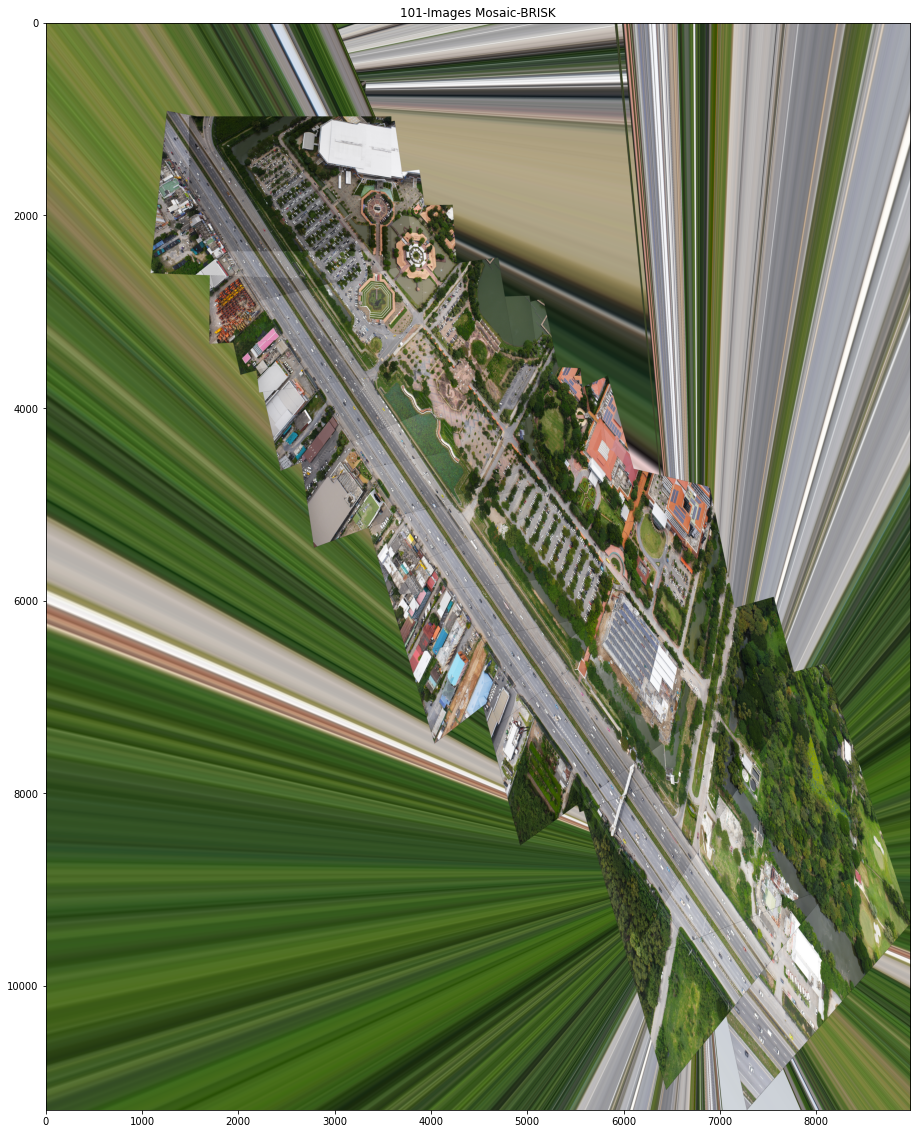

In [46]:
fig,ax =plt.subplots()
fig.set_size_inches(20,20)
ax.imshow(cv2.cvtColor(warp_imgs_all_brisk , cv2.COLOR_BGR2RGB))
ax.set_title('101-Images Mosaic-BRISK')